In [159]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import sys
import pickle

import re
from pprint import pprint
from scipy import interp
from scipy import sparse
from itertools import cycle

import time

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.lancaster import *
from nltk.stem.wordnet import *

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import gensim

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

In [552]:
import warnings
warnings.filterwarnings(action = 'once')

In [3]:
random_state = 7

# Load Data

In [4]:
reuters_path = '~/dev/rtc/data/text/reuters21578'

In [5]:
# https://raw.githubusercontent.com/ZhibingChen/DM-Reuters21578/master/reutersCSV.csv
csv_df = pd.read_csv(reuters_path + '/reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

In [6]:
csv_df.head()

,pid,fileName,purpose,topic.acq,topic.alum,topic.austdlr,topic.austral,topic.barley,topic.bfr,topic.bop,...,topic.tung,topic.tung.oil,topic.veg.oil,topic.wheat,topic.wool,topic.wpi,topic.yen,topic.zinc,doc.title,doc.text
0,1,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,2,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,3,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,4,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,5,0,train,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...


#### Peek at texts

In [7]:
# 1 -- 5
(title, text) = csv_df.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text)

STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT 

 Standard Oil Co and BP North America Inc said they plan to form a venture to manage the money market borrowing and investment activities of both companies.     BP North America is a subsidiary of British Petroleum Co Plc &lt;BP>, which also owns a 55 pct interest in Standard Oil.     The venture will be called BP/Standard Financial Trading and will be operated by Standard Oil under the oversight of a joint management committee.   Reuter 


#### Topics

In [8]:
all_topics = [ re.sub('topic\.', '', col) for col in csv_df.columns if col.startswith('topic.') ]
print('\n', 'num topics:', len(all_topics))
pd.DataFrame(all_topics, columns=['topic name']).head(15)


 num topics: 135


,topic name
0,acq
1,alum
2,austdlr
3,austral
4,barley
5,bfr
6,bop
7,can
8,carcass
9,castor.meal


### Prepare topics -- the labels we are going to predict

Add them to a dataframe in two ways

#### 1) As lists of zeros and ones -- for humans to read,

In [9]:
topics_binarized = np.array(csv_df.values[:,3:-3])

#### 2) As lists of strings -- for multi-label classifiers.

In [10]:
def topic_list_from_binarized(binarized):
    return [ topic for (has, topic) in zip(binarized, all_topics) if has == 1 ]

topic_lists = [ topic_list_from_binarized(binarized) for binarized in topics_binarized ]

#### Combine all

In [11]:
df = csv_df[[ 'pid', 'purpose', 'doc.title', 'doc.text' ]]
df = df.assign(topic_list = topic_lists)
df = df.assign(topics_binarized = topics_binarized.tolist())
df = df.assign(num_topics = np.array([ len(lst) for lst in topic_lists ]))
df.head()

,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
0,1,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,[cocoa],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
1,2,train,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,3,train,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,4,train,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,5,train,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,"[barley, corn, grain, oat, sorghum, wheat]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


### So the whole data is...

In [12]:
df_train = df[df['purpose'] == 'train']
df_test = df[df['purpose'] == 'test']

In [13]:
n_classes = len(all_topics)

In [14]:
print('total docs', len(df))
print('num train examples', len(df_train))
print('num test examples', len(df_test))
df.head()

total docs 21578
num train examples 14668
num test examples 6188


,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
0,1,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,[cocoa],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
1,2,train,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,3,train,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,4,train,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,5,train,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,"[barley, corn, grain, oat, sorghum, wheat]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


### Some stats

#### Num topics per document

total docs: 21578
docs with at least one topic: 11324
docs with more than one topic: 1859
docs with more than two topics: 523
docs with exactly one topic: 9465


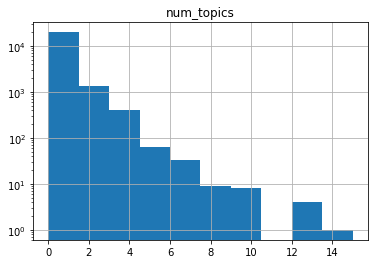

In [15]:
fig, ax = plt.subplots()
ax.set_yscale('log')

df[['num_topics']].hist(ax = ax)

print('total docs:', len(df))
print('docs with at least one topic:', len(df[df['num_topics'] > 0]))
print('docs with more than one topic:', len(df[df['num_topics'] > 1]))
print('docs with more than two topics:', len(df[df['num_topics'] > 2]))
print('docs with exactly one topic:', len(df[df['num_topics'] == 1]))

#### Num documents per topic

##### Calculate

In [16]:
really_want_to_recalc_num_docs_by_topic = False
if really_want_to_recalc_num_docs_by_topic:
    num_docs_by_topic = df.from_records(
        data = [ 
            (topic, len(df[df.apply(lambda row: topic in row['topic_list'], axis=1)]))
            for topic in all_topics
        ],
        columns = [ 'topic', 'num_docs' ]
    ).sort_values('num_docs', ascending = False)
    # beware not to overwrite data that is costly to compute again
    # num_docs_by_topic.to_csv(reuters_path + '/num_docs_by_topic.csv', index = False)
else:
    num_docs_by_topic = pd.read_csv(reuters_path + '/num_docs_by_topic.csv')
    num_docs_by_topic = num_docs_by_topic.sort_values('num_docs', ascending = False)

##### Show

[Text(0,0.5,'num_docs')]

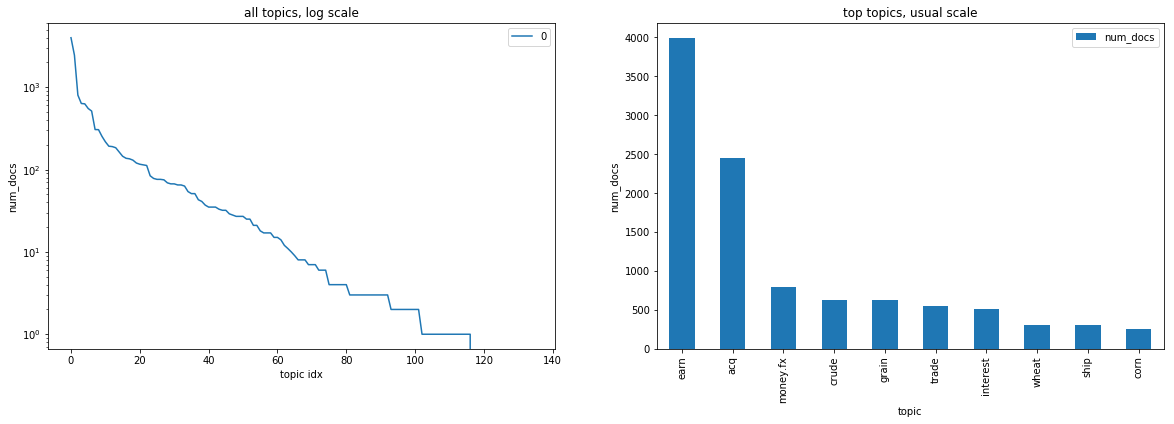

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('all topics, log scale')
axs[1].set_title('top topics, usual scale')
pd.DataFrame(num_docs_by_topic[['num_docs']].values).plot(ax = axs[0]).set(xlabel = 'topic idx', ylabel = 'num_docs')
num_docs_by_topic.head(10).plot(ax = axs[1], kind = 'bar', x = 'topic').set(ylabel = 'num_docs')

#### Num words per document

In [18]:
num_words = df[['doc.title', 'doc.text']].apply(
    lambda row: len((row['doc.title'] + ' ' + row['doc.text']).split()),
    axis = 1
)

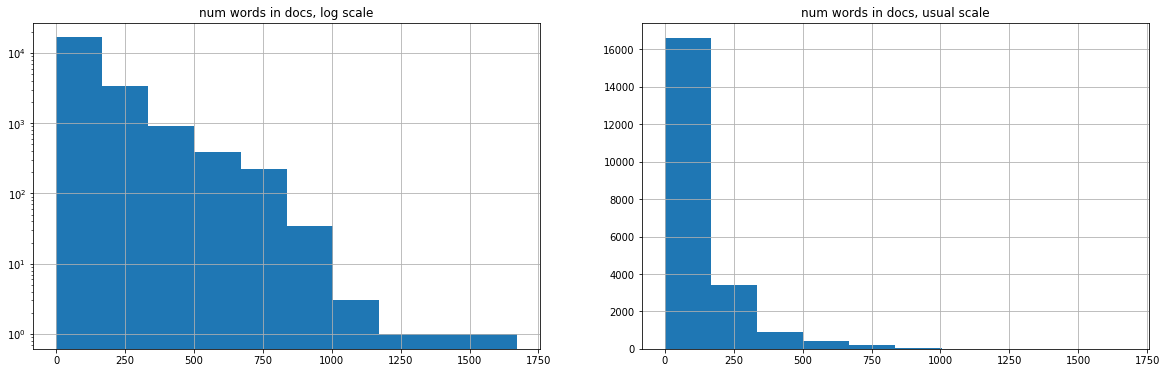

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('num words in docs, log scale')
axs[1].set_title('num words in docs, usual scale')

num_words.hist(ax = axs[0])
num_words.hist(ax = axs[1])

#### Total num distinct words and word counts

In [20]:
def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

In [21]:
counts_by_word = get_counts_by_word(
    df.apply(lambda row : row['doc.title'] + ' ' + row['doc.text'], axis = 1).values
)

In [22]:
len(counts_by_word.keys())

134890

## Keep only a few good topics and only single-topic docs

In [23]:
roughly_even_topics = [
    'money.fx',
    'crude',
    'grain',
    'trade',
    'interest',
]
all_topics = roughly_even_topics

#### Later we will need a special binary representation of labels
For compatibility with library functions that calculate metrics

In [24]:
roughly_even_topics_set = set(roughly_even_topics)
df = df[df.apply(
    lambda row: len(row['topic_list']) == 1 and set(row['topic_list']).issubset(roughly_even_topics_set),
    axis = 1
)]

In [25]:
binarizer = MultiLabelBinarizer(classes = roughly_even_topics)

In [26]:
topic_lists = df.apply(lambda row : row['topic_list'][0], axis = 1).values.reshape(len(df), 1)
roughly_even_topics_binarized = binarizer.fit_transform(topic_lists)
roughly_even_topics_binarized[:5]

array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

In [27]:
df = df.assign(topics_binarized = roughly_even_topics_binarized.tolist())

### So the data we will use is...

In [28]:
df_train = df[df['purpose'] == 'train']
df_test = df[df['purpose'] == 'test']

In [29]:
n_classes = len(all_topics)

In [30]:
print('total docs', len(df))
print('num train examples', len(df_train))
print('num test examples', len(df_test))
df.head()

total docs 1414
num train examples 943
num test examples 377


,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
46,47,train,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation plan, initially hailed at home and a...",[trade],"[0, 0, 0, 1, 0]",1
123,124,train,U.S. GRAIN CARLOADINGS FALL IN WEEK,"U.S. grain carloadings totaled 26,108 cars in ...",[grain],"[0, 0, 1, 0, 0]",1
126,127,train,DIAMOND SHAMROCK (DIA) CUTS CRUDE PRICES,Diamond Shamrock Corp said that effective toda...,[crude],"[0, 1, 0, 0, 0]",1
135,136,train,GAO LIKELY TO SHOW CERTS MORE COSTLY THAN CASH,A study on grain certificates due out shortly ...,[grain],"[0, 0, 1, 0, 0]",1
143,144,train,OPEC MAY HAVE TO MEET TO FIRM PRICES - ANALYSTS,OPEC may be forced to meet before a scheduled ...,[crude],"[0, 1, 0, 0, 0]",1


### Same stats as above -- this time, on the sub-sampled data

#### Num documents per topic

In [31]:
num_docs_by_topic = df.from_records(
    data = [ 
        (topic, len(df[df.apply(lambda row: topic in row['topic_list'], axis=1)]))
        for topic in all_topics
    ],
    columns = [ 'topic', 'num_docs' ]
).sort_values('num_docs', ascending = False)
# beware not to overwrite data that is costly to compute again
# num_docs_by_topic.to_csv(reuters_path + '/num_docs_by_topic.csv', index = False)

[Text(0,0.5,'num_docs')]

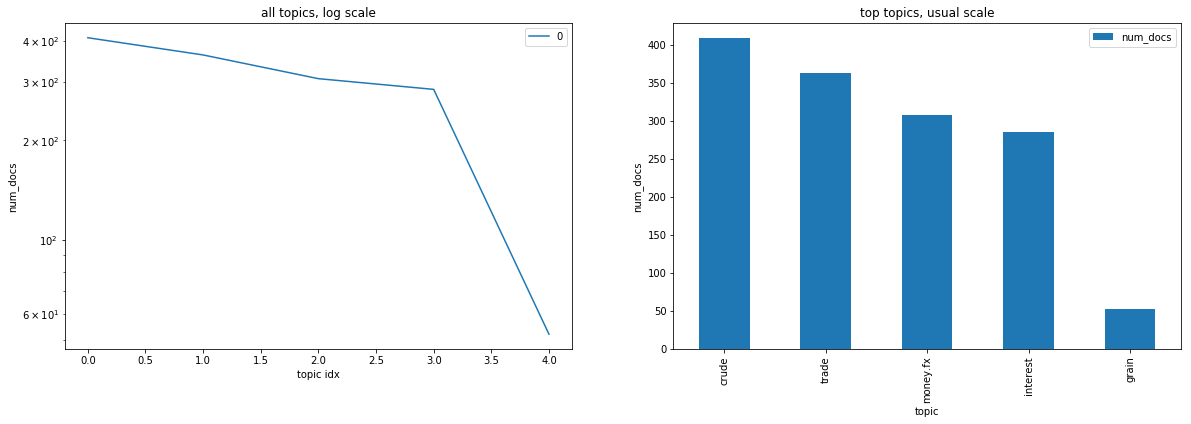

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('all topics, log scale')
axs[1].set_title('top topics, usual scale')
pd.DataFrame(num_docs_by_topic[['num_docs']].values).plot(ax = axs[0]).set(xlabel = 'topic idx', ylabel = 'num_docs')
num_docs_by_topic.head(10).plot(ax = axs[1], kind = 'bar', x = 'topic').set(ylabel = 'num_docs')

#### Num words per document

In [33]:
num_words = df[['doc.title', 'doc.text']].apply(
    lambda row: len((row['doc.title'] + ' ' + row['doc.text']).split()),
    axis = 1
)

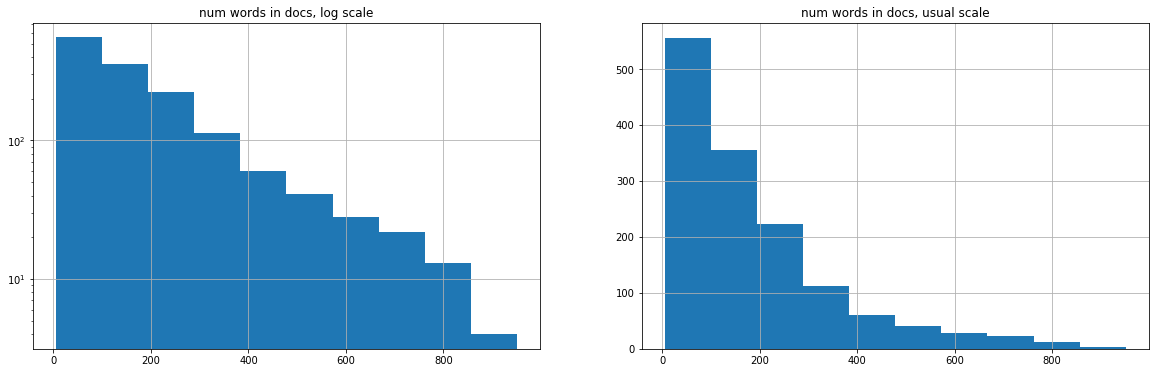

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('num words in docs, log scale')
axs[1].set_title('num words in docs, usual scale')

num_words.hist(ax = axs[0])
num_words.hist(ax = axs[1])

#### Total num distinct words and word counts

In [35]:
def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

In [36]:
counts_by_word = get_counts_by_word(
    df.apply(lambda row : row['doc.title'] + ' ' + row['doc.text'], axis = 1).values
)

In [37]:
len(counts_by_word.keys())

23568

# Create features

The whole task actually revolves around how we represent the documents as vectors that can be fed to a classifier.

Here we will use the Bag Of Words approach:

1. split each text to tokens and create a set of all words of all texts -- the vocabulary,
2. create a matrix in which rows correspond to docs and columns -- to words,
3. fill the matrix with either of:
  * 1 if the word is found in the doc and else 0,
  * word count in doc,
  * TF-IDF numbers.
  
Questions:

1. How to split the text to tokens ? By whitespace ? Punctuation ? Some other way ?
2. What if the words have different forms ?
3. What if there are lots of different numbers ?
4. What if there are common sequences of words, like "United Kingdom", "Russian Federation", "United States of America"
5. What if there are lots of words like "a", "the", "they" etc. that appear in many documets ?

### What do texts actually look like

In [38]:
# 1   -- just regular text
# 4   -- longer text
# 5   -- only title
# 6   -- has &lt; (see above) and some numbers
# 100 -- has a table of some sort
#
# some words are upper case, some lower, some even mixed (doc 5)
# a lot of punctuation
# numbers are in different formats
# Reuter word at the end of each document
# some words are abbreviated

(title, text) = df.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text)

U.S. GRAIN CARLOADINGS FALL IN WEEK 

 U.S. grain carloadings totaled 26,108 cars in the week ended February 21, down 2.2 pct from the previous week but 22.8 pct above the corresponding week a year ago, the Association of American Railroads reported.     Grain mill product loadings in the week totalled 11,382 cars, down 1.8 pct from the previous week but 7.6 pct above the same week a year earlier, the association said.  Reuter 


### Pre-process text

In [173]:
def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string):
    return re.sub(r'([0-9]+ ?)+', ' <num> ', string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ 
        stemmer.stem(word) if hasattr(stemmer, 'stem') else stemmer.lemmatize(word)
        for word in re.split(' ', string) if not word in stop_words 
    ])

In [174]:
stop_words = stopwords.words('english')

stemmer = LancasterStemmer()
# stemmer = PorterStemmer()

In [175]:
# nltk.download('wordnet')
# stemmer = WordNetLemmatizer()

In [176]:
def pre_process(string):
    s = lower_case(string)
    s = fix_lt(s)
    s = remove_reuter(s)
    s = strip_punctuation(s)
    s = remove_stop_words(s, stop_words)
    s = compact_whitespace(s)
    s = replace_numeric_with_literal(s)
    s = stem(s, stemmer)
    return s.strip()

In [177]:
example = 'Autobahn-FX 2, &lt;RMS> are now being actively developed; GDS decom will be finished by 2055 or 2056'
pre_process(example)

'autobahn fx  <num> rms act develop gds decom fin  <num>'

In [178]:
(title, text) = df.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text, '\n\n', pre_process(title + ' ' + text))

U.S. GRAIN CARLOADINGS FALL IN WEEK 

 U.S. grain carloadings totaled 26,108 cars in the week ended February 21, down 2.2 pct from the previous week but 22.8 pct above the corresponding week a year ago, the Association of American Railroads reported.     Grain mill product loadings in the week totalled 11,382 cars, down 1.8 pct from the previous week but 7.6 pct above the same week a year earlier, the association said.  Reuter  

 u grain carload fal week u grain carload tot  <num> car week end febru  <num> pct prevy week  <num> pct correspond week year ago assocy am railroad report grain mil produc load week total  <num> car  <num> pct prevy week  <num> pct week year ear assocy said reut


#### Get pre-processed text sets

In [179]:
def pre_process_df(df):
    return df.apply(lambda row : pre_process(row['doc.title'] + ' ' + row['doc.text']), axis = 1).values

In [180]:
pre_processed_train = pre_process_df(df_train)

In [181]:
pre_processed_test = pre_process_df(df_test)

#### Check vocabulary

In [182]:
counts_by_word_pre_processed_train = get_counts_by_word(pre_processed_train)

In [183]:
len(counts_by_word_pre_processed_train)

5197

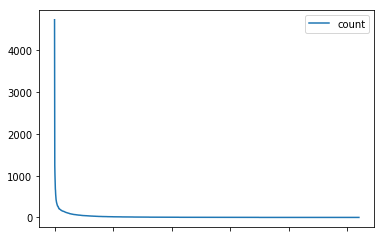

In [184]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False).plot()

In [185]:
num_words = 3000

In [188]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False)[:num_words].head(20)

,count
<num>,4736
said,3300
trad,1538
u,1298
bank,1250
oil,1108
bil,1062
pct,1029
rat,964
reut,897


In [187]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False)[:num_words].tail()

,count
chronic,2
abus,2
raw,2
eug,2
expatry,2


In [189]:
top_words = list(counts_by_word_pre_processed_train.items())
top_words.sort(key = lambda it: it[1])
top_words.reverse()
top_words = [ word for word, count in top_words[:num_words] ]
print(len(top_words))
top_words[:20]

3000


['<num>',
 'said',
 'trad',
 'u',
 'bank',
 'oil',
 'bil',
 'pct',
 'rat',
 'reut',
 'mln',
 'market',
 'would',
 'year',
 'dlrs',
 'off',
 'pric',
 'jap',
 'produc',
 'econom']

In [201]:
top_words[20:40]

['last',
 'stat',
 'min',
 'cur',
 'export',
 'govern',
 'new',
 'country',
 'foreign',
 'import',
 'on',
 'also',
 'opec',
 'doll',
 'nat',
 'cut',
 'agr',
 'week',
 'barrel',
 'crud']

In [205]:
def replace_rare_words_with_literal(string, top_words):
    return ' '.join([ (word if word in top_words else '<unk>') for word in re.split(' ', string) ])

def replace_frequent_words_with_literal(string, top_words):
    return ' '.join([ (word if word not in top_words or word == '<num>' else '<skip>') for word in re.split(' ', string) ])

def replace_redundant_words_with_literal(string, top_words):
    return replace_frequent_words_with_literal(
        replace_rare_words_with_literal(string, top_words),
        top_words[:20]
    )

In [206]:
pre_processed_train = [ 
    replace_redundant_words_with_literal(doc, top_words) for doc in pre_processed_train
]

pre_processed_test = [ 
    replace_redundant_words_with_literal(doc, top_words) for doc in pre_processed_test
]

In [207]:
print(pre_processed_train[:3])
print()
print(pre_processed_test[:3])

['brazil ant infl plan <unk> annivers infl plan init <unk> hom abroad <unk> <unk> <unk> toward first annivers amid soar <unk> widespread short foreign pay cris annount last febru <unk> <unk> plan froz <unk> fix valu new <unk> cur end widespread index <unk> bid halt country <unk> <unk> <unk> infl <unk> within <unk> plan collaps situ wors although infl least <unk> work lead <unk> <unk> <unk> <unk> plan accompany dram revers foreign <unk> account <unk> <unk> brazil an <unk> surplus sufficy cov <unk> <unk> <unk> <unk> nee serv <unk> <unk> <unk> dlr foreign debt first nin month <unk> <unk> seem target rep month surplus av on <unk> <unk> export divert import increas avoid domest short <unk> surpl plung <unk> <unk> <unk> <unk> octob sint av <unk> <unk> <unk> <unk>', '<unk> grain carload fal week <unk> grain carload tot <unk> <unk> car week end febru <unk> <unk> <unk> prevy week <unk> <unk> <unk> correspond week <unk> ago assocy am railroad report grain mil <unk> load week total <unk> <unk> ca

### Vectorize text

In [208]:
vectorizer = TfidfVectorizer(ngram_range = (1, 1))

vectorizer.fit(pre_processed_train)

X_train = vectorizer.transform(pre_processed_train, copy=True)
X_test = vectorizer.transform(pre_processed_test, copy=True)

In [209]:
X_train.shape

(943, 2967)

### Topic modeling

In [471]:
def sklearn2gensim(X):
    return gensim.matutils.Sparse2Corpus(X.T)

In [472]:
X_train_gensim = sklearn2gensim(X_train)

In [473]:
X_train_gensim[0]

[(2936, 0.08143920989556722),
 (2931, 0.05035707303908859),
 (2922, 0.055109524967646456),
 (2905, 0.17518761159358573),
 (2821, 0.06278917321494236),
 (2785, 0.689603015603012),
 (2700, 0.0651908713993181),
 (2616, 0.05602975223624104),
 (2580, 0.1473706721334371),
 (2579, 0.04971785854208858),
 (2559, 0.08580596518119218),
 (2414, 0.08759380579679286),
 (2394, 0.06316398487986795),
 (2392, 0.04674315474127239),
 (2366, 0.09272413884837719),
 (2334, 0.0588923966845403),
 (2315, 0.07156387540219197),
 (2202, 0.08022423353701177),
 (2158, 0.0680453352485615),
 (1957, 0.08420668725356915),
 (1944, 0.22520657464494592),
 (1881, 0.05119591083021481),
 (1797, 0.03615762121278928),
 (1785, 0.06913001809311595),
 (1745, 0.06857798994254179),
 (1733, 0.03577812391696347),
 (1719, 0.046615060300246),
 (1676, 0.09400526574972058),
 (1464, 0.06563087615449707),
 (1461, 0.05019472816342841),
 (1450, 0.03208184802338931),
 (1305, 0.07294474522816677),
 (1300, 0.272181340994246),
 (1288, 0.079099341

In [474]:
id2word = {v: k for k, v in vectorizer.vocabulary_.items()}
id2word

{0: 'ab',
 1: 'abd',
 2: 'abdel',
 3: 'abdelaz',
 4: 'abdulaz',
 5: 'abid',
 6: 'abl',
 7: 'abol',
 8: 'abroad',
 9: 'abs',
 10: 'absorb',
 11: 'abu',
 12: 'acceiv',
 13: 'accel',
 14: 'accentu',
 15: 'access',
 16: 'accid',
 17: 'accommod',
 18: 'accompany',
 19: 'accompl',
 20: 'accord',
 21: 'account',
 22: 'accus',
 23: 'achiev',
 24: 'acid',
 25: 'acknowledg',
 26: 'acquir',
 27: 'acquisit',
 28: 'acr',
 29: 'across',
 30: 'act',
 31: 'ad',
 32: 'adam',
 33: 'addit',
 34: 'address',
 35: 'adequ',
 36: 'adh',
 37: 'adjust',
 38: 'adm',
 39: 'admin',
 40: 'admit',
 41: 'adopt',
 42: 'adv',
 43: 'advers',
 44: 'advoc',
 45: 'aeg',
 46: 'affair',
 47: 'affect',
 48: 'afford',
 49: 'affy',
 50: 'afr',
 51: 'afric',
 52: 'afternoon',
 53: 'ag',
 54: 'agend',
 55: 'aggrav',
 56: 'aggreg',
 57: 'aggress',
 58: 'agip',
 59: 'ago',
 60: 'agr',
 61: 'agree',
 62: 'agricult',
 63: 'agrio',
 64: 'aguarico',
 65: 'ahead',
 66: 'ahm',
 67: 'aid',
 68: 'aim',
 69: 'air',
 70: 'airb',
 71: 'aircra

In [475]:
lda = gensim.models.ldamodel.LdaModel(
    corpus = X_train_gensim,
    id2word = id2word,
    num_topics = 50,
    per_word_topics = True
)

In [476]:
ldayed = lda[X_train_gensim]

In [477]:
tmp = lda.print_topics()
tmp.sort(key = lambda it: it[0])
tmp

[(0,
  '0.056*"unk" + 0.007*"canad" + 0.004*"semiconduc" + 0.004*"powerin" + 0.004*"barrel" + 0.004*"sanct" + 0.004*"stg" + 0.004*"crud" + 0.004*"yeut" + 0.004*"ecuad"'),
 (5,
  '0.044*"unk" + 0.006*"fut" + 0.006*"cbt" + 0.005*"amount" + 0.005*"doll" + 0.005*"deal" + 0.005*"buy" + 0.004*"ar" + 0.004*"californ" + 0.004*"fso"'),
 (7,
  '0.048*"unk" + 0.006*"doll" + 0.006*"fed" + 0.005*"repurchas" + 0.005*"canad" + 0.004*"cut" + 0.004*"monet" + 0.004*"volck" + 0.004*"restrict" + 0.004*"hurt"'),
 (10,
  '0.100*"unk" + 0.009*"prim" + 0.007*"money" + 0.006*"rev" + 0.006*"surpl" + 0.005*"rais" + 0.005*"forecast" + 0.005*"stg" + 0.005*"febru" + 0.005*"lend"'),
 (11,
  '0.079*"unk" + 0.009*"opec" + 0.007*"barrel" + 0.006*"prim" + 0.006*"subroto" + 0.005*"day" + 0.005*"sumit" + 0.004*"defend" + 0.004*"stat" + 0.004*"delib"'),
 (13,
  '0.062*"unk" + 0.008*"canad" + 0.005*"fee" + 0.004*"cut" + 0.004*"unch" + 0.004*"report" + 0.004*"gat" + 0.004*"effect" + 0.003*"chevron" + 0.003*"reduc"'),
 (20,
 

In [478]:
ldayed[0]

([(1, 0.7548981), (40, 0.10538328)],
 [(2936, [1]),
  (2931, [40]),
  (2922, [1]),
  (2905, [1]),
  (2821, [1, 40]),
  (2785, [1, 40]),
  (2700, [1]),
  (2616, [1, 40]),
  (2580, [1]),
  (2579, [1]),
  (2559, [1]),
  (2414, [1]),
  (2394, [1]),
  (2392, [1, 40]),
  (2366, [40, 1]),
  (2334, [1, 40]),
  (2315, [1]),
  (2202, [1]),
  (2158, [1]),
  (1957, [1]),
  (1944, [1]),
  (1881, [40]),
  (1797, [1]),
  (1785, [1]),
  (1745, [1]),
  (1733, [40]),
  (1719, [1]),
  (1676, [1]),
  (1464, [1]),
  (1461, [1]),
  (1450, [1]),
  (1305, [1]),
  (1300, [1]),
  (1288, [1]),
  (1282, [1]),
  (1267, [1]),
  (1215, [40]),
  (1164, [1]),
  (1055, [1]),
  (1019, [1]),
  (997, [40]),
  (991, [1]),
  (964, [1]),
  (929, [1]),
  (855, [1]),
  (781, [1]),
  (768, [1]),
  (762, [1]),
  (760, [1]),
  (648, [1, 40]),
  (621, [1]),
  (605, [1]),
  (597, [1, 40]),
  (591, [1]),
  (486, [1]),
  (316, [40]),
  (267, [1]),
  (198, [1]),
  (195, [1]),
  (124, [1]),
  (121, [1, 40]),
  (120, [1]),
  (111, [40])

In [479]:
def gensim2sklearn(ldayed):
    return gensim.matutils.corpus2csc([
        topics 
        for topics, word_topics, word_topics_weights
        in ldayed
    ]).T

In [480]:
X_train_topics = gensim2sklearn(ldayed)

In [481]:
X_train_topics[0].todense()

matrix([[0.        , 0.75295836, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.10732292, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]])

In [482]:
X_train.shape, X_train_topics.shape

((943, 2967), (943, 50))

In [483]:
X_train_with_topics = sparse.hstack((X_train, X_train_topics)).A

In [484]:
def with_topics(X, lda):
    X_gensim = sklearn2gensim(X)
    ldayed = lda[X_gensim]
    X_topics = gensim2sklearn(ldayed)
    return sparse.hstack((X, X_topics)).A

In [485]:
X_train_with_topics = with_topics(X_train, lda)

In [486]:
X_train_with_topics.shape

(943, 3017)

In [487]:
X_test_with_topics = with_topics(X_test, lda)

### Prepare labels

In [322]:
def single_label(df):
    return df.apply(lambda row : row['topic_list'][0], axis = 1).values

In [323]:
def binarized(df):
    return sparse.csr_matrix(df.apply(lambda row : row['topics_binarized'], axis = 1).values.tolist())

In [324]:
y_train = single_label(df_train)
y_test = single_label(df_test)

# Train the model

In [488]:
# y_train_labels = binarizer.inverse_transform(y_train)

In [489]:
# clf = MLPClassifier()
clf = MultinomialNB()
# clf = LogisticRegression(multi_class='multinomial', solver='lbfgs') # accepts array of single labels
# clf = LinearSVC()

clf = clf.fit(X_train, y_train)

In [490]:
# clf_topics = MLPClassifier()
clf_topics = MultinomialNB()
# clf_topics = LogisticRegression(multi_class='multinomial', solver='lbfgs') # accepts array of single labels
# clf_topics = LinearSVC()

clf_topics = clf_topics.fit(X_train_with_topics, y_train)

# Check quality

In [494]:
def print_evaluation_scores(y_test, predicted, show = True):
    if show:
        print('accuracy', accuracy_score(y_test, predicted))
        for avg in [ 'micro', 'macro', 'weighted' ]:
            print('f1', avg, f1_score(y_test, predicted, average = avg))
            print('precision', avg, average_precision_score(y_test, predicted, average = avg))
    return f1_score(y_test, predicted, average = 'micro')

In [495]:
def check_quality(clf, X_test, y_test, show = True):
    y_test_predicted_labels = clf.predict(X_test)
    # y_test_predicted_scores = clf.decision_function(X_test)
    
    y_test_predicted_labels_binary = binarizer.transform(y_test_predicted_labels.reshape(len(y_test_predicted_labels), 1))
    y_test_binary = binarizer.transform(y_test.reshape(len(y_test), 1))
    
    return print_evaluation_scores(y_test_binary, y_test_predicted_labels_binary, show)

In [496]:
check_quality(clf, X_test, y_test)

accuracy 0.8143236074270557
f1 micro 0.8143236074270557
precision micro 0.7002582161276023
f1 macro 0.6458224047868572
precision macro 0.5766341815691591
f1 weighted 0.7996184916930537
precision weighted 0.7165782762239856


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8143236074270557

In [497]:
check_quality(clf, X_train, y_train)

accuracy 0.9003181336161188
f1 micro 0.9003181336161188
precision micro 0.8305091149947877
f1 macro 0.7436565062533964
precision macro 0.7012581563135557
f1 weighted 0.8817508443191279
precision weighted 0.8277349291563834


0.9003181336161188

In [498]:
check_quality(clf_topics, X_test_with_topics, y_test)

accuracy 0.8090185676392573
f1 micro 0.8090185676392573
precision micro 0.6927073292572241
f1 macro 0.6444657586974202
precision macro 0.5774732912875562
f1 weighted 0.7978270394630511
precision weighted 0.7171959883520158


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8090185676392573

In [499]:
check_quality(clf_topics, X_train_with_topics, y_train)

accuracy 0.8897136797454931
f1 micro 0.8897136797454931
precision micro 0.8136476959771672
f1 macro 0.7348999914212635
precision macro 0.6875555596386167
f1 weighted 0.8715148084135868
precision weighted 0.8117023683555472


0.8897136797454931

## Grid

In [507]:
def test_topic_modeling(num_topics, clf):
    if num_topics > 0:
        X_train_gensim = sklearn2gensim(X_train)
        lda = gensim.models.ldamodel.LdaModel(
            corpus = X_train_gensim,
            id2word = id2word,
            num_topics = num_topics,
            per_word_topics = True
        )
        X_train_with_topics = with_topics(X_train, lda)
        X_test_with_topics = with_topics(X_test, lda)
        clf = clf.fit(X_train_with_topics, y_train)
        train = check_quality(clf, X_train_with_topics, y_train, show = False)
        test = check_quality(clf, X_test_with_topics, y_test, show = False)
    else:
        clf = clf.fit(X_train, y_train)
        train = check_quality(clf, X_train, y_train, show = False)
        test = check_quality(clf, X_test, y_test, show = False)
    return clf, train, test

In [508]:
results = []
for clf_factory in [
    MultinomialNB,
    lambda: LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    LinearSVC,
]:
    for num_topics in [
        -1,
        5,
        10,
        15,
        20,
        50,
        100,
        150,
        200,
    ]:
        print('------------------------------------------')
        clf, train, test = test_topic_modeling(num_topics, clf_factory())
        clf_name = type(clf).__name__
        print('clf: {0}, num_topics: {1}'.format(clf_name, num_topics))
        print('TRAIN {0}'.format(train))
        print('TEST  {0}'.format(test))
        results.append((clf_name, num_topics, train, test))

------------------------------------------
clf: MultinomialNB, num_topics: -1
TRAIN 0.9003181336161188
TEST  0.8143236074270557
------------------------------------------


clf: MultinomialNB, num_topics: 5
TRAIN 0.8854718981972428
TEST  0.8275862068965517
------------------------------------------


clf: MultinomialNB, num_topics: 20
TRAIN 0.8791092258748674
TEST  0.7824933687002653
------------------------------------------


clf: MultinomialNB, num_topics: 50
TRAIN 0.8791092258748674
TEST  0.7984084880636605
------------------------------------------
clf: MultinomialNB, num_topics: 100
TRAIN 0.9045599151643691
TEST  0.8037135278514589
------------------------------------------


clf: LogisticRegression, num_topics: -1
TRAIN 0.95864262990456
TEST  0.9151193633952255
------------------------------------------


clf: LogisticRegression, num_topics: 5
TRAIN 0.9522799575821846
TEST  0.9071618037135278
------------------------------------------


clf: LogisticRegression, num_topics: 20
TRAIN 0.95864262990456
TEST  0.8912466843501327
------------------------------------------


clf: LogisticRegression, num_topics: 50
TRAIN 0.9628844114528102
TEST  0.9124668435013262
------------------------------------------
clf: LogisticRegression, num_topics: 100
TRAIN 0.9713679745493107
TEST  0.9257294429708223


In [544]:
rdf = pd.DataFrame.from_records(results, columns = ['clf', 'num_topics', 'train', 'test'])

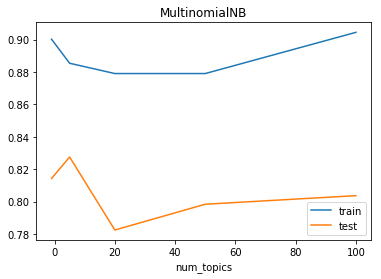

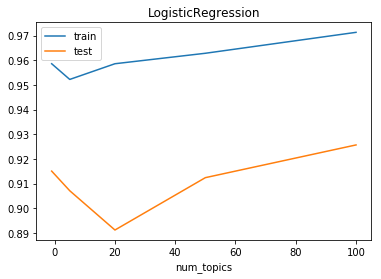

In [551]:
rdfs = []
for clf_name in [
    'MultinomialNB',
    'LogisticRegression'
]:
    cur_rdf = rdf.loc[rdf['clf'] == clf_name][['num_topics', 'train', 'test']].set_index('num_topics').T
    rdfs.append((clf_name, cur_rdf))
    cur_rdf.T.plot(title = clf_name)

In [554]:
for rdf in rdfs:
    print(rdf[0])
    display(rdf[1])

MultinomialNB


num_topics,-1,5,20,50,100
train,0.900318,0.885472,0.879109,0.879109,0.904560
test,0.814324,0.827586,0.782493,0.798408,0.803714


LogisticRegression


num_topics,-1,5,20,50,100
train,0.958643,0.952280,0.958643,0.962884,0.971368
test,0.915119,0.907162,0.891247,0.912467,0.925729


## Fiddle around with the classifier

In [69]:
df_test[4:9]

,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
14911,14912,test,JAPAN GIVEN LITTLE HOPE OF AVOIDING U.S. SANCT...,A top U.S. Official said Japan has little chan...,[trade],"[0, 0, 0, 1, 0]",1
14986,14987,test,STOLTENBERG SEES MOVES TO STRENGTHEN PARIS ACCORD,West German Finance Minister Gerhard Stoltenbe...,[money.fx],"[1, 0, 0, 0, 0]",1
15047,15048,test,TOP OFFICIALS ARRIVE AT TREASURY FOR G-5 TALKS,Top officials of leading industrial nations ar...,[money.fx],"[1, 0, 0, 0, 0]",1
15048,15049,test,FED EXPECTED TO SET CUSTOMER REPURCHASES,The Federal Reserve is expected to intervene i...,[interest],"[0, 0, 0, 0, 1]",1
15091,15092,test,"FED SETS OVERNIGHT SYSTEM REPURCHASES, FED SAYS",,[interest],"[0, 0, 0, 0, 1]",1


In [70]:
print(df_test.iloc[5]['doc.title'] + '\n\n' + df_test.iloc[5]['doc.text'])

STOLTENBERG SEES MOVES TO STRENGTHEN PARIS ACCORD

West German Finance Minister Gerhard Stoltenberg said today's meetings of major industrial countries would look at ways of strengthening the Paris accord on stabilizing foreign exchange rates.     Stoltenberg told journalists he saw no fundamental weakness of the February 22 agreement of the Group of Five countries and Canada to keep exchange rates near the then-current levels.     But he declined to say what measures would be discussed ahead of a communique of the Group of Seven ministers later today.     Stoltenberg and Bundesbank President Karl Otto Poehl said the importance of the Paris agreement, also known as the Louvre accord, had been underestimated.     Stoltenberg said there is greater agreement now among major countries than six months ago, at the time of the annual meeting of the International Monetary Fund and World Bank, marked by sharp discord between the United States and its major trading partners.     "There is no fun

## Interpreting features

In [71]:
num_top_features = 10
pd.set_option('max_colwidth', 200)
pd.DataFrame.from_records(
    columns = [ 'topic', 'top_words' ],
    data = [ (
        cls, 
        [ vectorizer.get_feature_names()[i] for i in np.argpartition(coefs, -num_top_features)[-num_top_features:] ]
    ) for cls, coefs in zip(clf.classes_, clf.coef_) ]
)

,topic,top_words
0,crude,"[company, opec, oil, refinery, petrole, barrel, energy, bpd, pric, crud]"
1,grain,"[elev, cer, cert, agricult, farm, crop, ton, soviet, grain, usd]"
2,interest,"[discount, num, point, cut, interest, fed, prim, bank, pct, rat]"
3,money.fx,"[system, stg, bank, exchang, doll, money, monet, market, stabl, cur]"
4,trade,"[janu, gat, import, surpl, bil, export, trad, japanes, jap, deficit]"


# Full Flow

In [72]:
# PARAMETERS -------------------------------------------------------
CASE_NAME = 'CASE_NAME'
TOPICS = 'TOPICS'
MODEL = 'MODEL'
MODEL_NAME = 'MODEL_NAME'
VECTORIZER = 'VECTORIZER'
VECTORIZER_NAME = 'VECTORIZER_NAME'
PP_LOWER_CASE = 'PP_LOWER_CASE'
PP_FIX_LT = 'PP_FIX_LT'
PP_REMOVE_REUTER = 'PP_REMOVE_REUTER'
PP_STRIP_PUNCTUATION = 'PP_STRIP_PUNCTUATION'
PP_REMOVE_STOP_WORDS = 'PP_REMOVE_STOP_WORDS'
PP_COMPACT_WHITESPACE = 'PP_COMPACT_WHITESPACE'
PP_NUMERIC = 'PP_NUMERIC'
PP_REPLACE_NUMERIC_WITH_LITERAL = 'PP_REPLACE_NUMERIC_WITH_LITERAL'
PP_NUMERIC_AS_IS = 'PP_NUMERIC_AS_IS'
PP_NUMERIC_DROP = 'PP_NUMERIC_DROP'
PP_STEM = 'PP_STEM'
PP_STEM_PORTER = 'PP_STEM_PORTER'
PP_STEM_LANCASTER = 'PP_STEM_LANCASTER'
PP_LEMMATIZE = 'PP_LEMMATIZE'
PP_STEM_NONE = 'PP_STEM_NONE'
NUM_TOP_WORDS_TO_TAKE = 'NUM_TOP_WORDS_TO_TAKE'
RARE_WORDS = 'RARE_WORDS'
RARE_WORDS_REPLACE = 'RARE_WORDS_REPLACE'
RARE_WORDS_DROP = 'RARE_WORDS_DROP'
RARE_WORDS_AS_IS = 'RARE_WORDS_AS_IS'

def default_parameters():
    return {
        MODEL_NAME : "LogisticRegression(multi_class='multinomial', solver='lbfgs')",
        VECTORIZER_NAME : "TfidfVectorizer(ngram_range = (1, 1))",
        CASE_NAME : 'default -- logreg with tfidf',
        MODEL : LogisticRegression(multi_class='multinomial', solver='lbfgs'), # accepts array of single labels
        VECTORIZER : TfidfVectorizer(ngram_range = (1, 1)),
        TOPICS : [ 'money.fx', 'crude', 'grain', 'trade', 'interest', ], # classes for single-label multi-class model
        PP_LOWER_CASE : True,
        PP_FIX_LT : True,
        PP_REMOVE_REUTER : True,
        PP_STRIP_PUNCTUATION : True,
        PP_REMOVE_STOP_WORDS : True,
        PP_COMPACT_WHITESPACE : True,
        PP_NUMERIC: PP_REPLACE_NUMERIC_WITH_LITERAL, # PP_NUMERIC_DROP # PP_NUMERIC_AS_IS
        PP_STEM : PP_STEM_LANCASTER, # PP_STEM_PORTER # PP_STEM_LANCASTER # PP_LEMMATIZE # PP_STEM_NONE
        RARE_WORDS : RARE_WORDS_REPLACE, # RARE_WORDS_DROP
        NUM_TOP_WORDS_TO_TAKE : 3000, # top words by count to build vocabulary of
    }

# LABEL BINARIZATION -----------------------------------------------

def topic_list_from_binarized(binarized, topics):
    return [ topic for (has, topic) in zip(binarized, topics) if has == 1 ]

def single_label(df):
    return df.apply(lambda row : row['topic_list'][0], axis = 1).values

def binarized(df):
    return sparse.csr_matrix(df.apply(lambda row : row['topics_binarized'], axis = 1).values.tolist())

# PREPROCESSING ----------------------------------------------------

def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string, literal = '<num> '):
    return re.sub(r'([0-9]+ ?)+', literal, string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ stemmer.stem(word) for word in re.split(' ', string) if not word in stop_words ])

def lemmatize(string, lemmatizer):
    return ' '.join([ lemmatizer.lemmatize(word) for word in re.split(' ', string) if not word in stop_words ])

stop_words = stopwords.words('english')

def pre_process(params, string):
    s = string
    if params[PP_LOWER_CASE]:
        s = lower_case(string)
    if params[PP_FIX_LT]:
        s = fix_lt(s)
    if params[PP_REMOVE_REUTER]:
        s = remove_reuter(s)
    if params[PP_STRIP_PUNCTUATION]:
        s = strip_punctuation(s)
    if params[PP_REMOVE_STOP_WORDS]:
        s = remove_stop_words(s, stop_words)
    if params[PP_COMPACT_WHITESPACE]:
        s = compact_whitespace(s)
    if params[PP_NUMERIC] == PP_REPLACE_NUMERIC_WITH_LITERAL:
        s = replace_numeric_with_literal(s)
    elif params[PP_NUMERIC] == PP_NUMERIC_DROP:
        s = replace_numeric_with_literal(s, '')
    if params[PP_STEM] == PP_STEM_LANCASTER:
        stemmer = LancasterStemmer()
        s = stem(s, stemmer)
    elif params[PP_STEM] == PP_STEM_PORTER:
        stemmer = PorterStemmer()
        s = stem(s, stemmer)
    elif params[PP_STEM] == PP_LEMMATIZE:
        lemmatizer = WordNetLemmatizer()
        s = lemmatize(s, lemmatizer)
    return s.strip()

def pre_process_df(params, df):
    return df.apply(lambda row : pre_process(params, row['doc.title'] + ' ' + row['doc.text']), axis = 1).values

def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

def replace_rare_words_with_literal(string, top_words, literal = '<unk>'):
    return ' '.join([ (word if word in top_words else literal) for word in re.split(' ', string) ])

# METRICS --------------------------------------------------------

def get_and_print_evaluation_scores(y_test, predicted, verbose = True):
    accuracy = accuracy_score(y_test, predicted)
    precision_and_f1 = dict()
    if verbose:
        print('accuracy', accuracy)
    for avg in [ 'micro', 'macro', 'weighted' ]:
        precision = average_precision_score(y_test, predicted, average = avg)
        f1 = f1_score(y_test, predicted, average = avg)
        precision_and_f1[avg] = (precision, f1)
        if verbose:
            print('f1', avg, f1)
            print('precision', avg, precision)
        # 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
        # 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
        # 'weighted': Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
    return (accuracy, precision_and_f1)

# ACTUAL FLOW ----------------------------------------------------

def run(params, verbose = True):
    print('------------------------------------------------------')
    print(time.ctime(time.time()))
    print(params[CASE_NAME])

    topics = params[TOPICS]
    n_classes = len(topics)
    topics_set = set(topics)

    # LOAD DATA --------------------------------------------------------
    started_loading = time.time()
    
    reuters_path = '~/dev/rtc/data/text/reuters21578'
    # https://raw.githubusercontent.com/ZhibingChen/DM-Reuters21578/master/reutersCSV.csv
    csv_df = pd.read_csv(reuters_path + '/reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

    # ORGANIZE DATA ----------------------------------------------------

    # take only what's needed (columns 'topic_list' and 'num_topics' added separately below)
    df = csv_df[[ 'pid', 'purpose', 'doc.title', 'doc.text' ]]

    # get specified topics
    all_topics = [ re.sub('topic\.', '', col) for col in csv_df.columns if col.startswith('topic.') ]

    # store topics for all docs before filtering them according to the specified topics list
    all_topics_binary = np.array(csv_df.values[:,3:-3])
    topic_lists_long = [ topic_list_from_binarized(binary, all_topics) for binary in all_topics_binary ]
    df = df.assign(topic_list = topic_lists_long)
    df = df.assign(num_topics = np.array([ len(lst) for lst in topic_lists_long ]))

    # keep only docs that have exactly one topic and that is within the specified topics list
    df = df[df.apply(
        lambda row: row['num_topics'] == 1 and set(row['topic_list']).issubset(topics_set),
        axis = 1
    )]

    # Binarizing labels for API compatibility
    # could have taken from CSV with some dataframe wrangling -- in this case
    # in general -- a Binarizer may well be needed anyway, so showing it
    
    binarizer = MultiLabelBinarizer(classes = topics)
    topic_lists = df.apply(lambda row : row['topic_list'][0], axis = 1).values.reshape(len(df), 1)
    topics_binarized = binarizer.fit_transform(topic_lists)
    df = df.assign(topics_binarized = topics_binarized.tolist())
    
    # train-test split -- as per the dataset markup
    df_train = df[df['purpose'] == 'train']
    df_test = df[df['purpose'] == 'test']
        
    # PRE-PROCESS TEXT --------------------------------------------------
    started_pre_processing = time.time()

    # case, punctuation, stop-words, whitespace etc.
    pre_processed_train = pre_process_df(params, df_train)
    pre_processed_test = pre_process_df(params, df_test)
    
    # deal with rare words
    if params[NUM_TOP_WORDS_TO_TAKE] > 0:
        num_words = params[NUM_TOP_WORDS_TO_TAKE]
        counts_by_word = get_counts_by_word(pre_processed_train)
        top_words = list(counts_by_word.items())
        top_words.sort(key = lambda it: it[1])
        top_words.reverse()
        top_words = [ word for word, count in top_words[:num_words] ]
        if params[RARE_WORDS] == RARE_WORDS_REPLACE:
            pre_processed_train = [ replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_train ]
            pre_processed_test = [ replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_test ]
        elif params[RARE_WORDS] == RARE_WORDS_DROP:
            pre_processed_train = [ replace_rare_words_with_literal(doc, top_words, '') for doc in pre_processed_train ]
            pre_processed_test = [ replace_rare_words_with_literal(doc, top_words, '') for doc in pre_processed_test ]

    # CREATE FEATURE REPRESENTATION AND LABELS ---------------------------
    started_vectorizing = time.time()

    vectorizer = params[VECTORIZER]

    vectorizer.fit(pre_processed_train)

    X_train = vectorizer.transform(pre_processed_train)
    X_test = vectorizer.transform(pre_processed_test)

    y_train = single_label(df_train)
    y_test = single_label(df_test)
    # y_train_labels = binarizer.inverse_transform(y_train)

    # TRAIN THE MODEL ----------------------------------------------------
    started_training = time.time()

    clf = params[MODEL]

    clf = clf.fit(X_train, y_train)

    # CHECK METRICS ------------------------------------------------------
    started_checking_metrics = time.time()

    y_test_predicted_labels = clf.predict(X_test)
    try:
        # binarize for metrics calculation
        y_test_predicted_labels_binary = binarizer.transform(y_test_predicted_labels.reshape(len(y_test_predicted_labels), 1))
        y_test_binary = binarizer.transform(y_test.reshape(len(y_test), 1))

        # print metrics
        started_rendering_metrics = time.time()
        print()
        metrics = get_and_print_evaluation_scores(y_test_binary, y_test_predicted_labels_binary, verbose)

        # print most important features
        top_features = []
        if (hasattr(clf, 'coef_')):
            num_top_features = 10 # min(10, clf.coef_.shape[0])
            top_features = pd.DataFrame.from_records(
                columns = [ 'topic', 'top_words' ],
                data = [ (
                    cls, 
                    [ vectorizer.get_feature_names()[i] for i in np.argpartition(coefs, -num_top_features)[-num_top_features:] ]
                ) for cls, coefs in zip(clf.classes_, clf.coef_[:len(clf.classes_)]) ]
            )
        if verbose:
            display(top_features)
        
        done = time.time()
        timing = { name : round(value, 2) for name, value in {
            'total'             : done                      - started_loading,
            'loading'           : started_pre_processing    - started_loading,
            'pre-processing'    : started_vectorizing       - started_pre_processing,
            'vectorizing'       : started_training          - started_vectorizing,
            'training'          : started_checking_metrics  - started_training,
            'checking metrics'  : started_rendering_metrics - started_checking_metrics,
            'rendering metrics' : done                      - started_rendering_metrics,
        }.items() }
        
        if verbose:
            print()
            print('timing:')
            for k, v in timing.items():
                print(k, ':', v)
            print()
        
        return (metrics, top_features, timing)
    except:
        message = "Could not calculate metrics: " + str(sys.exc_info())
        if verbose:
            print(message)
        return message


In [73]:
params = default_parameters()
smoke = run(params)

------------------------------------------------------
Thu Sep 20 00:52:47 2018
default -- logreg with tfidf

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.936284968768048
precision macro 0.8921255460350176
f1 weighted 0.9382848227855798
precision weighted 0.8970242590844048


,topic,top_words
0,crude,"[company, opec, oil, refinery, petrole, barrel, energy, bpd, pric, crud]"
1,grain,"[elev, cer, cert, agricult, farm, crop, ton, soviet, grain, usd]"
2,interest,"[discount, num, point, cut, interest, fed, prim, bank, pct, rat]"
3,money.fx,"[system, stg, bank, exchang, doll, money, monet, market, stabl, cur]"
4,trade,"[janu, gat, import, surpl, bil, export, trad, japanes, jap, deficit]"



timing:
training : 0.63
pre-processing : 25.79
total : 31.14
rendering metrics : 0.23
loading : 3.69
checking metrics : 0.01
vectorizing : 0.79



### Exhaustive grid search

In [74]:
results = []

In [219]:
for pp_remove_reuter in [ True, False ]:
    for pp_fix_lt in [ True, False ]:
        for pp_lower_case in [ True, False ]:
            for pp_strip_punctuation in [ True, False ]:
                for pp_remove_stop_words in [ True, False ]:
                    for pp_compact_whitespace in [ True ]: # , False ]:
                        for pp_numeric in [ PP_REPLACE_NUMERIC_WITH_LITERAL, PP_NUMERIC_DROP, PP_NUMERIC_AS_IS ]:
                            for pp_stem in [ PP_STEM_LANCASTER, PP_STEM_PORTER, PP_STEM_NONE, PP_LEMMATIZE, -100 ]:
                                for num_top_words_to_take in [ -1 ]: # [ 3000, 6000, 12000, -1 ]:
                                    for rare_words in ([ RARE_WORDS_REPLACE, RARE_WORDS_DROP ] if num_top_words_to_take > 0 else [ RARE_WORDS_AS_IS ]): 
                                        for vectorizer_name, vectorizer in [
                                            ('CountVectorizer()', CountVectorizer()),
                                            ('TfidfVectorizer(ngram_range = (1, 1))', TfidfVectorizer(ngram_range = (1, 1))),
                                            ('TfidfVectorizer(ngram_range = (1, 2))', TfidfVectorizer(ngram_range = (1, 2))),
                                            ('TfidfVectorizer(ngram_range = (1, 3))', TfidfVectorizer(ngram_range = (1, 3))),
                                            ('TfidfVectorizer(ngram_range = (2, 2))', TfidfVectorizer(ngram_range = (2, 2))),
                                        ]:
                                            for model_name, model in [
                                                ("MLPClassifier(alpha=1, max_iter=500)", MLPClassifier(alpha=1, max_iter=500)),
                                                ("LogisticRegression(multi_class='multinomial', solver='lbfgs')", LogisticRegression(multi_class='multinomial', solver='lbfgs')),
                                                ("MultinomialNB()", MultinomialNB()),
                                                ("KNeighborsClassifier(15)", KNeighborsClassifier(15)),
                                                ("LinearSVC()", LinearSVC()),
                                                ("DecisionTreeClassifier(max_depth=50)", DecisionTreeClassifier(max_depth=50)),
                                                ("RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)", RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)),
                                            ]:
                                                if pp_stem == -100:
                                                    raise Exception('done!')
                                                params = [
                                                    (MODEL_NAME, model_name),
                                                    (VECTORIZER_NAME, vectorizer_name),
                                                    (TOPICS, [ 'money.fx', 'crude', 'grain', 'trade', 'interest', ]),
                                                    (PP_LOWER_CASE, pp_lower_case),
                                                    (PP_FIX_LT, pp_fix_lt),
                                                    (PP_REMOVE_REUTER, pp_remove_reuter),
                                                    (PP_STRIP_PUNCTUATION, pp_strip_punctuation),
                                                    (PP_REMOVE_STOP_WORDS, pp_remove_stop_words),
                                                    (PP_COMPACT_WHITESPACE, pp_compact_whitespace),
                                                    (PP_NUMERIC, pp_numeric),
                                                    (PP_STEM, pp_stem),
                                                    (RARE_WORDS, rare_words),
                                                    (NUM_TOP_WORDS_TO_TAKE, num_top_words_to_take),
                                                ]
                                                params.insert(0, (CASE_NAME, '\n'.join([ str(kv) for kv in params ])))
                                                bin_params = dict(params)
                                                bin_params[MODEL] = model
                                                bin_params[VECTORIZER] = vectorizer
                                                metrics = run(bin_params)
                                                results.append((params, metrics))

------------------------------------------------------
Mon Aug 27 20:07:46 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9442970822281167
f1 micro 0.9442970822281167
precision micro 0.9028375630589113
f1 macro 0.94195700939887
precision macro 0.9001002983649931
f1 weighted 0.9439456172538648
precision weighted 0.9048288179576469


[]


timing:
total : 54.99
checking metrics : 0.01
training : 34.61
vectorizing : 0.6
loading : 4.18
rendering metrics : 0.06
pre-processing : 15.53

------------------------------------------------------
Mon Aug 27 20:08:41 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9336870026525199
f1 micro 0.9336870026525199
precision micro 0.8850340183917428
f1 macro 0.9328446464935227
precision macro 0.8856816621060851
f1 weighted 0.9335478302057115
precision weighted 0.8887520219151788


,topic,top_words
0,crude,"[reag, rais, wti, cts, energy, barrel, pric, crud, oil, bbl]"
1,grain,"[vs, week, import, farm, usd, soviet, crop, estim, grain, ton]"
2,interest,"[discount, bundesbank, credit, interest, bank, prim, pct, rat, cut, fed]"
3,money.fx,"[say, bank, stabl, money, two, buy, system, exchang, cur, doll]"
4,trade,"[volck, baldrig, export, good, see, janu, year, japanes, deficit, trad]"



timing:
total : 17.82
checking metrics : 0.01
training : 1.44
vectorizing : 0.59
loading : 3.39
rendering metrics : 0.48
pre-processing : 11.92

------------------------------------------------------
Mon Aug 27 20:08:59 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9363395225464191
f1 micro 0.9363395225464191
precision micro 0.8894637969731722
f1 macro 0.943055417700579
precision macro 0.9063523770944247
f1 weighted 0.9358794233347157
precision weighted 0.8947703334269101


,topic,top_words
0,crude,"[crud, barrel, dlrs, opec, produc, mln, oil, num, pric, said]"
1,grain,"[farm, would, reut, mln, num, grain, off, cert, year, said]"
2,interest,"[interest, reut, num, prim, pct, bank, said, bil, cut, rat]"
3,money.fx,"[exchang, rat, mln, bil, doll, cur, num, bank, market, said]"
4,trade,"[japanes, reut, jap, year, export, would, bil, num, said, trad]"



timing:
total : 16.43
checking metrics : 0.01
training : 0.01
vectorizing : 0.59
loading : 3.33
rendering metrics : 0.48
pre-processing : 12.02

------------------------------------------------------
Mon Aug 27 20:09:16 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7824933687002652
f1 micro 0.7824933687002653
precision micro 0.6557971983198362
f1 macro 0.693395082523891
precision macro 0.5920352279428079
f1 weighted 0.7854400755012674
precision weighted 0.6911933166349395


[]


timing:
total : 15.77
checking metrics : 0.05
training : 0.0
vectorizing : 0.58
loading : 3.27
rendering metrics : 0.04
pre-processing : 11.82

------------------------------------------------------
Mon Aug 27 20:09:32 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9230769230769231
f1 micro 0.9230769230769231
precision micro 0.8674556213017752
f1 macro 0.906036365225163
precision macro 0.8391013372935218
f1 weighted 0.9228660158204505
precision weighted 0.870916345465942


,topic,top_words
0,crude,"[nor, barrel, bbl, pric, reag, opec, oil, distil, crud, gasolin]"
1,grain,"[up, iwc, crop, ussr, import, ton, grain, usd, soviet, estim]"
2,interest,"[littl, spokeswom, rat, cut, arrang, dan, pct, prim, ros, low]"
3,money.fx,"[fel, necess, buy, via, money, exchang, system, doll, two, cur]"
4,trade,"[baldrig, go, janu, sanct, ahead, year, trad, good, deficit, japanes]"



timing:
total : 16.45
checking metrics : 0.01
training : 0.23
vectorizing : 0.62
loading : 3.27
rendering metrics : 0.49
pre-processing : 11.83

------------------------------------------------------
Mon Aug 27 20:09:48 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8275862068965517
f1 micro 0.8275862068965517
precision micro 0.7193816884661117
f1 macro 0.8428798649899422
precision macro 0.763850144805297
f1 weighted 0.8253110409355422
precision weighted 0.737881939610954


[]


timing:
total : 16.01
checking metrics : 0.01
training : 0.14
vectorizing : 0.57
loading : 3.33
rendering metrics : 0.04
pre-processing : 11.93

------------------------------------------------------
Mon Aug 27 20:10:04 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7957559681697612
f1 micro 0.7957559681697612
precision micro 0.6740763672438418
f1 macro 0.6280835983853995
precision macro 0.5491219607104888
f1 weighted 0.7773524814449977
precision weighted 0.682075261233209


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 21.83
checking metrics : 0.5
training : 5.09
vectorizing : 0.59
loading : 3.83
rendering metrics : 0.05
pre-processing : 11.77

------------------------------------------------------
Mon Aug 27 20:10:26 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.946949602122016
f1 micro 0.946949602122016
precision micro 0.9073236285346411
f1 macro 0.9435381797734838
precision macro 0.9031738490685702
f1 weighted 0.9466354248787825
precision weighted 0.9099428109348713


[]


timing:
total : 54.64
checking metrics : 0.01
training : 38.82
vectorizing : 0.61
loading : 3.32
rendering metrics : 0.06
pre-processing : 11.82

------------------------------------------------------
Mon Aug 27 20:11:21 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9416445623342176
f1 micro 0.9416445623342176
precision micro 0.8983655693067566
f1 macro 0.9197621223277472
precision macro 0.8644886448972141
f1 weighted 0.9407958527820781
precision weighted 0.8996138179646831


,topic,top_words
0,crude,"[company, petrole, bpd, energy, opec, crud, refinery, barrel, oil, pric]"
1,grain,"[cer, elev, ton, usd, soviet, grain, farm, crop, agricult, cert]"
2,interest,"[rais, point, bank, rat, num, fed, prim, pct, interest, cut]"
3,money.fx,"[par, stabl, market, monet, money, bank, exchang, stg, cur, doll]"
4,trade,"[janu, import, surpl, gat, bil, japanes, deficit, export, jap, trad]"



timing:
total : 16.95
checking metrics : 0.01
training : 0.72
vectorizing : 0.59
loading : 3.18
rendering metrics : 0.46
pre-processing : 11.99

------------------------------------------------------
Mon Aug 27 20:11:38 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8541114058355438
f1 micro 0.8541114058355437
precision micro 0.7586840124112602
f1 macro 0.6834207945497626
precision macro 0.6244743436558787
f1 weighted 0.842522509059663
precision weighted 0.7720722108869544


,topic,top_words
0,crude,"[bpd, mln, dlrs, oil, barrel, num, said, crud, pric, opec]"
1,grain,"[usd, farm, ton, agricult, soviet, crop, said, cert, num, grain]"
2,interest,"[bil, rais, cut, said, fed, prim, pct, rat, num, bank]"
3,money.fx,"[said, doll, cur, bank, market, num, bil, mln, stg, money]"
4,trade,"[import, year, said, trad, num, deficit, bil, japanes, jap, export]"



timing:
total : 17.03
checking metrics : 0.01
training : 0.01
vectorizing : 0.6
loading : 3.18
rendering metrics : 0.47
pre-processing : 12.77

------------------------------------------------------
Mon Aug 27 20:11:55 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9257294429708223
f1 micro 0.9257294429708223
precision micro 0.8718291129889044
f1 macro 0.9057178872753424
precision macro 0.842049967702654
f1 weighted 0.9251277994392866
precision weighted 0.8749469950416103


[]


timing:
total : 15.9
checking metrics : 0.06
training : 0.0
vectorizing : 0.61
loading : 3.22
rendering metrics : 0.04
pre-processing : 11.97

------------------------------------------------------
Mon Aug 27 20:12:11 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9496021220159151
f1 micro 0.9496021220159151
precision micro 0.9118237657339459
f1 macro 0.9543857112369871
precision macro 0.9230648816665964
f1 weighted 0.9493531444418064
precision weighted 0.9147740022841186


,topic,top_words
0,crude,"[bbl, petrole, dril, pric, opec, barrel, crud, refinery, oil, energy]"
1,grain,"[ton, drought, usd, elev, mca, cer, crop, grain, farm, cert]"
2,interest,"[littl, point, bundesbank, prim, rat, interest, pct, bank, fed, borrow]"
3,money.fx,"[bank, market, interv, stabl, system, money, monet, cur, exchang, doll]"
4,trade,"[import, year, develop, ec, trad, jap, deficit, export, good, japanes]"



timing:
total : 16.6
checking metrics : 0.01
training : 0.06
vectorizing : 0.59
loading : 3.23
rendering metrics : 0.48
pre-processing : 12.23

------------------------------------------------------
Mon Aug 27 20:12:28 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8328912466843501
f1 micro 0.8328912466843501
precision micro 0.727129579466541
f1 macro 0.840662679365248
precision macro 0.7526789838152167
f1 weighted 0.8318649408742553
precision weighted 0.7423364741095465


[]


timing:
total : 16.48
checking metrics : 0.01
training : 0.15
vectorizing : 0.59
loading : 3.74
rendering metrics : 0.04
pre-processing : 11.96

------------------------------------------------------
Mon Aug 27 20:12:44 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.830238726790451
f1 micro 0.8302387267904511
precision micro 0.7232485981045389
f1 macro 0.6619279874714656
precision macro 0.5926916572272211
f1 weighted 0.813949208475503
precision weighted 0.7281888594669383


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 21.84
checking metrics : 0.5
training : 4.71
vectorizing : 0.65
loading : 3.35
rendering metrics : 0.04
pre-processing : 12.59

------------------------------------------------------
Mon Aug 27 20:13:06 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9416445623342176
f1 micro 0.9416445623342176
precision micro 0.8983655693067566
f1 macro 0.9388770841882875
precision macro 0.8959710274507098
f1 weighted 0.9413514599543192
precision weighted 0.9017576940691113


[]


timing:
total : 568.86
checking metrics : 0.02
training : 551.82
vectorizing : 1.63
loading : 3.49
rendering metrics : 0.05
pre-processing : 11.86

------------------------------------------------------
Mon Aug 27 20:22:35 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9283819628647215
f1 micro 0.9283819628647215
precision micro 0.8762166763996089
f1 macro 0.8836634868082335
precision macro 0.8142615502750985
f1 weighted 0.9263043054916474
precision weighted 0.876609320608431


,topic,top_words
0,crude,"[petrole, energy, bpd, barrel, pric, oil, opec, crud, num dlrs, refinery]"
1,grain,"[elev, mln ton, ton, usd, soviet, farm, agricult, crop, cert, grain]"
2,interest,"[rat num, fed, prim rat, interest rat, prim, pct num, num pct, bank, pct, rat]"
3,money.fx,"[stabl, money, exchang rat, money market, mln stg, stg, bank, exchang, cur, doll]"
4,trade,"[gat, bil, trad, jap, num bil, deficit, surpl, trad deficit, export, japanes]"



timing:
total : 34.73
checking metrics : 0.01
training : 9.61
vectorizing : 1.66
loading : 3.44
rendering metrics : 8.19
pre-processing : 11.82

------------------------------------------------------
Mon Aug 27 20:23:10 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8541114058355438
f1 micro 0.8541114058355437
precision micro 0.7586840124112602
f1 macro 0.6855664351435147
precision macro 0.6267131593817525
f1 weighted 0.8420173523083567
precision weighted 0.7695629470075641


,topic,top_words
0,crude,"[mln, dlrs, opec, pric, num dlrs, said, barrel, crud, oil, num]"
1,grain,"[usd, ton, crop, farm, agricult, cert, num, soviet, said, grain]"
2,interest,"[fed, prim rat, rat num, pct num, num pct, bank, pct, rat, num, prim]"
3,money.fx,"[bil, market, money, money market, num mln, mln, bank, stg, num, mln stg]"
4,trade,"[import, deficit, export, num, jap, trad, japanes, num bil, said, bil]"



timing:
total : 25.2
checking metrics : 0.01
training : 0.03
vectorizing : 1.66
loading : 3.27
rendering metrics : 8.2
pre-processing : 12.02

------------------------------------------------------
Mon Aug 27 20:23:35 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.9376225501941633
precision macro 0.8935887554693916
f1 weighted 0.9387582516765405
precision weighted 0.8977312234195066


[]


timing:
total : 17.78
checking metrics : 0.07
training : 0.0
vectorizing : 1.66
loading : 3.5
rendering metrics : 0.04
pre-processing : 12.51

------------------------------------------------------
Mon Aug 27 20:23:53 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9442970822281167
f1 micro 0.9442970822281167
precision micro 0.9028375630589113
f1 macro 0.9493878365256618
precision macro 0.9150596411462566
f1 weighted 0.9439641304621927
precision weighted 0.906198672411057


,topic,top_words
0,crude,"[num dlrs, refinery, opec, energy, barrel, expl, petrole, pric, crud, oil]"
1,grain,"[soviet, agricult, farm, drought, elev, usd, cer, crop, cert, grain]"
2,interest,"[pct num, fed, pct, bank, rat, prim, num pct, prim rat, interest, interest rat]"
3,money.fx,"[interv, money, stabl, exchang rat, money market, doll, cur, monet, bank, exchang]"
4,trade,"[gat, surpl, good, japanes, ec, trad deficit, deficit, jap, export, trad]"



timing:
total : 27.06
checking metrics : 0.01
training : 0.23
vectorizing : 1.64
loading : 3.82
rendering metrics : 9.4
pre-processing : 11.96

------------------------------------------------------
Mon Aug 27 20:24:20 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8249336870026526
f1 micro 0.8249336870026526
precision micro 0.7155288505512598
f1 macro 0.8170345092704956
precision macro 0.7175825464334216
f1 weighted 0.8213629092726795
precision weighted 0.7323028814922315


[]


timing:
total : 17.73
checking metrics : 0.01
training : 0.67
vectorizing : 1.7
loading : 3.48
rendering metrics : 0.05
pre-processing : 11.83

------------------------------------------------------
Mon Aug 27 20:24:38 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.53315649867374
f1 micro 0.53315649867374
precision micro 0.3776245523432938
f1 macro 0.31944082233288934
precision macro 0.3237891534598719
f1 weighted 0.40531151061289467
precision weighted 0.3915634169584594


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 22.83
checking metrics : 0.91
training : 4.83
vectorizing : 1.64
loading : 3.52
rendering metrics : 0.05
pre-processing : 11.88

------------------------------------------------------
Mon Aug 27 20:25:01 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9257294429708223
f1 micro 0.9257294429708223
precision micro 0.8718291129889044
f1 macro 0.8812955074469698
precision macro 0.8106555157075974
f1 weighted 0.9235667557867367
precision weighted 0.8723957897730285


[]


timing:
total : 1199.72
checking metrics : 0.04
training : 1181.25
vectorizing : 3.11
loading : 3.27
rendering metrics : 0.06
pre-processing : 12.0

------------------------------------------------------
Mon Aug 27 20:45:01 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9230769230769231
f1 micro 0.9230769230769231
precision micro 0.8674556213017752
f1 macro 0.847565924618246
precision macro 0.7760002764845387
f1 weighted 0.9189676090504686
precision weighted 0.8673172954054643


,topic,top_words
0,crude,"[ecuad, bpd, num dlrs, barrel, pric, opec, crud, oil, energy, refinery]"
1,grain,"[elev, mln ton, ton, agricult, farm, soviet, usd, crop, grain, cert]"
2,interest,"[rat num, num pct num, pct num, prim rat, rat, interest rat, bank, pct, prim, num pct]"
3,money.fx,"[money, exchang rat, money market, num mln stg, mln stg, exchang, doll, bank, stg, cur]"
4,trade,"[trad deficit, gat, japanes, deficit, surpl, jap, trad, export, num bil, bil]"



timing:
total : 59.34
checking metrics : 0.01
training : 19.22
vectorizing : 4.0
loading : 3.43
rendering metrics : 20.02
pre-processing : 12.66

------------------------------------------------------
Mon Aug 27 20:46:00 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8541114058355438
f1 micro 0.8541114058355437
precision micro 0.7586840124112602
f1 macro 0.6852951650485268
precision macro 0.6256743683069381
f1 weighted 0.8416514393693535
precision weighted 0.7683312950936005


,topic,top_words
0,crude,"[dlrs, mln, num dlrs, barrel, pric, said, crud, opec, oil, num]"
1,grain,"[usd, ton, agricult, grain, cert, crop, said, soviet, num, farm]"
2,interest,"[rat num pct, rat num, prim, num pct, pct, pct num, bank, num pct num, rat, num]"
3,money.fx,"[market, num mln, money market, money, mln, num mln stg, stg, num, mln stg, bank]"
4,trade,"[year, import, export, num, num bil, jap, said, bil, japanes, trad]"



timing:
total : 37.53
checking metrics : 0.01
training : 0.08
vectorizing : 2.95
loading : 3.1
rendering metrics : 20.01
pre-processing : 11.38

------------------------------------------------------
Mon Aug 27 20:46:37 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9416445623342176
f1 micro 0.9416445623342176
precision micro 0.8983655693067566
f1 macro 0.9401071802138251
precision macro 0.8976121067657681
f1 weighted 0.9414464350233765
precision weighted 0.9020402902472007


[]


timing:
total : 18.13
checking metrics : 0.07
training : 0.0
vectorizing : 2.96
loading : 3.17
rendering metrics : 0.04
pre-processing : 11.89

------------------------------------------------------
Mon Aug 27 20:46:56 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9416445623342176
f1 micro 0.9416445623342176
precision micro 0.8983655693067566
f1 macro 0.9470135714479708
precision macro 0.9112232891302326
f1 weighted 0.941299445238011
precision weighted 0.9019111511974471


,topic,top_words
0,crude,"[num dlrs, petrole, oil, opec, crud, barrel, pric, energy, refinery, expl]"
1,grain,"[drought, ton, elev, usd, farm, soviet, agricult, crop, grain, cert]"
2,interest,"[point, fed, prim rat, prim, pct, interest, bank, num pct, interest rat, rat]"
3,money.fx,"[interv, money, monet, stabl, exchang rat, money market, cur, doll, exchang, bank]"
4,trade,"[import, ec, gat, jap, export, trad deficit, deficit, surpl, japanes, trad]"



timing:
total : 39.7
checking metrics : 0.01
training : 0.45
vectorizing : 2.94
loading : 3.42
rendering metrics : 21.06
pre-processing : 11.81

------------------------------------------------------
Mon Aug 27 20:47:35 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8196286472148541
f1 micro 0.8196286472148541
precision micro 0.7078653898922809
f1 macro 0.8310784684525581
precision macro 0.7393729589450021
f1 weighted 0.8200151264835872
precision weighted 0.725800648471122


[]


timing:
total : 21.25
checking metrics : 0.01
training : 1.59
vectorizing : 3.01
loading : 3.7
rendering metrics : 0.04
pre-processing : 12.9

------------------------------------------------------
Mon Aug 27 20:47:57 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5013262599469496
f1 micro 0.5013262599469496
precision micro 0.3510627669230066
f1 macro 0.2818286857105842
precision macro 0.2990759638724768
f1 weighted 0.3616238387708445
precision weighted 0.3624622565717983


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 25.64
checking metrics : 1.19
training : 4.68
vectorizing : 3.07
loading : 3.22
rendering metrics : 0.04
pre-processing : 13.44

------------------------------------------------------
Mon Aug 27 20:48:22 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8673740053050398
f1 micro 0.8673740053050399
precision micro 0.7788628640178994
f1 macro 0.7791828042073431
precision macro 0.6864408652853125
f1 weighted 0.8621135909754366
precision weighted 0.783771739484487


[]


timing:
total : 562.01
checking metrics : 0.01
training : 546.78
vectorizing : 1.19
loading : 3.03
rendering metrics : 0.04
pre-processing : 10.94

------------------------------------------------------
Mon Aug 27 20:57:45 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8488063660477454
f1 micro 0.8488063660477454
precision micro 0.7507109738336301
f1 macro 0.7136832420110136
precision macro 0.6322207609098984
f1 weighted 0.8389016981642249
precision weighted 0.7558136167458349


,topic,top_words
0,crude,"[oil min, oil import, oil company, mln bpd, num bpd, num dlrs, crud oil, oil pric, num barrel, mln barrel]"
1,grain,"[ton vs, usd estim, cert program, wint crop, ton num, agricult depart, grain import, mln ton, soviet grain, grain produc]"
2,interest,"[bank said, bas rat, discount rat, lend rat, rais prim, interest rat, pct num, rat num, num pct, prim rat]"
3,money.fx,"[england said, fed say, maj nat, deal said, bank england, foreign exchang, mln stg, cent bank, exchang rat, money market]"
4,trade,"[off said, mln dlrs, trad min, deficit num, trad war, trad bil, trad deficit, unit stat, num bil, trad surpl]"



timing:
total : 33.79
checking metrics : 0.01
training : 8.13
vectorizing : 3.26
loading : 3.13
rendering metrics : 7.03
pre-processing : 12.23

------------------------------------------------------
Mon Aug 27 20:58:18 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8726790450928382
f1 micro 0.8726790450928382
precision micro 0.7870329067255804
f1 macro 0.702373579636582
precision macro 0.6458479415189049
f1 weighted 0.858539112863787
precision weighted 0.7874919905112523


,topic,top_words
0,crude,"[dlrs bbl, crud oil, num cts, mln barrel, num dlrs, rais crud, num bpd, num mln, oil pric, mln bpd]"
1,grain,"[vs num, usd estim, ton vs, grain import, num pct, grain produc, num mln, soviet grain, mln ton, agricult depart]"
2,interest,"[pct effect, bas rat, num day, lend rat, interest rat, rais prim, prim rat, rat num, pct num, num pct]"
3,money.fx,"[num pct, around num, cent bank, england said, num bil, bank england, exchang rat, mln stg, num mln, money market]"
4,trade,"[last year, num mln, trad bil, num bil, off said, trad deficit, bil dlrs, trad surpl, mln dlrs, unit stat]"



timing:
total : 26.43
checking metrics : 0.01
training : 0.05
vectorizing : 1.75
loading : 3.16
rendering metrics : 9.11
pre-processing : 12.35

------------------------------------------------------
Mon Aug 27 20:58:45 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8859416445623343
f1 micro 0.8859416445623343
precision micro 0.8077042686573466
f1 macro 0.8492819625362387
precision macro 0.752758845180835
f1 weighted 0.8862444512134227
precision weighted 0.8154665311477424


[]


timing:
total : 17.43
checking metrics : 0.03
training : 0.0
vectorizing : 1.34
loading : 4.59
rendering metrics : 0.04
pre-processing : 11.42

------------------------------------------------------
Mon Aug 27 20:59:02 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.896551724137931
f1 micro 0.896551724137931
precision micro 0.8244946492271107
f1 macro 0.8909583448055141
precision macro 0.8196467467350989
f1 weighted 0.896545664005021
precision weighted 0.8319957633737853


,topic,top_words
0,crude,"[oil produc, mln barrel, crud oil, oil min, num barrel, num bpd, oil company, num dlrs, oil pric, oil import]"
1,grain,"[num ton, wint crop, grain produc, agricult depart, grain elev, grain import, cert program, min num, soviet grain, mln ton]"
2,interest,"[arrang num, discount rat, credit policy, lend rat, rais prim, pct num, rat num, interest rat, prim rat, num pct]"
3,money.fx,"[west germany, fed say, maj nat, monet policy, mln stg, exchang rat, money market, cent bank, deal said, foreign exchang]"
4,trade,"[gen agr, deficit num, prim min, trad min, num bil, trad war, trad bil, trad deficit, trad surpl, unit stat]"



timing:
total : 24.59
checking metrics : 0.01
training : 0.18
vectorizing : 1.43
loading : 3.62
rendering metrics : 7.57
pre-processing : 11.78

------------------------------------------------------
Mon Aug 27 20:59:27 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7798408488063661
f1 micro 0.7798408488063662
precision micro 0.6521835797057604
f1 macro 0.7494698369379794
precision macro 0.6157116568363021
f1 weighted 0.7820614314132786
precision weighted 0.6704163283061927


[]


timing:
total : 17.55
checking metrics : 0.01
training : 0.99
vectorizing : 1.25
loading : 3.46
rendering metrics : 0.06
pre-processing : 11.79

------------------------------------------------------
Mon Aug 27 20:59:45 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5172413793103449
f1 micro 0.5172413793103449
precision micro 0.36409036860879906
f1 macro 0.30823564503440737
precision macro 0.3275463348866525
f1 weighted 0.38658488825720977
precision weighted 0.38873090403148486


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 27.16
checking metrics : 0.77
training : 8.42
vectorizing : 1.48
loading : 3.73
rendering metrics : 0.06
pre-processing : 12.7

------------------------------------------------------
Mon Aug 27 21:00:12 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.9363197626191668
precision macro 0.8916002105847582
f1 weighted 0.938566868657529
precision weighted 0.8967190017591565


[]


timing:
total : 52.6
checking metrics : 0.01
training : 35.28
vectorizing : 0.6
loading : 4.25
rendering metrics : 0.06
pre-processing : 12.39

------------------------------------------------------
Mon Aug 27 21:01:05 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9310344827586207
f1 micro 0.9310344827586207
precision micro 0.8806183115338883
f1 macro 0.9300673014036758
precision macro 0.8815465661325455
f1 weighted 0.9308547447404845
precision weighted 0.884579273350668


,topic,top_words
0,crude,"[wti, reagan, ct, rais, energi, price, barrel, crude, bbl, oil]"
1,grain,"[vs, minu, week, import, soviet, usda, tonn, grain, crop, estim]"
2,interest,"[credit, bundesbank, discount, bank, cut, prime, pct, interest, fed, rate]"
3,money.fx,"[stabil, market, system, bank, two, buy, currenc, exchang, dollar, money]"
4,trade,"[volcker, export, baldrig, januari, see, good, year, japanes, deficit, trade]"



timing:
total : 17.7
checking metrics : 0.01
training : 1.48
vectorizing : 0.59
loading : 3.5
rendering metrics : 0.58
pre-processing : 11.54

------------------------------------------------------
Mon Aug 27 21:01:23 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9283819628647215
f1 micro 0.9283819628647215
precision micro 0.8762166763996089
f1 macro 0.9354101297459912
precision macro 0.8947544741174607
f1 weighted 0.9277161020574619
precision weighted 0.8822968487166363


,topic,top_words
0,crude,"[bpd, crude, barrel, mln, num, price, opec, oil, said, dlr]"
1,grain,"[agricultur, reuter, offici, year, mln, would, certif, said, num, grain]"
2,interest,"[market, interest, num, pct, reuter, said, rate, prime, cut, bank]"
3,money.fx,"[stg, exchang, rate, mln, currenc, market, dollar, bank, said, num]"
4,trade,"[japanes, dlr, billion, would, reuter, trade, year, said, japan, num]"



timing:
total : 16.59
checking metrics : 0.01
training : 0.01
vectorizing : 1.23
loading : 3.43
rendering metrics : 0.97
pre-processing : 10.94

------------------------------------------------------
Mon Aug 27 21:01:40 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7931034482758621
f1 micro 0.7931034482758621
precision micro 0.6703923900118907
f1 macro 0.7033530508514927
precision macro 0.6077815326945217
f1 weighted 0.7969024017510526
precision weighted 0.7086866716934015


[]


timing:
total : 16.92
checking metrics : 0.05
training : 0.0
vectorizing : 0.6
loading : 3.87
rendering metrics : 0.04
pre-processing : 12.36

------------------------------------------------------
Mon Aug 27 21:01:57 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9336870026525199
f1 micro 0.9336870026525199
precision micro 0.8850340183917428
f1 macro 0.9325697843806949
precision macro 0.8849584311728931
f1 weighted 0.9337345304176266
precision weighted 0.888575759281421


,topic,top_words
0,crude,"[north, barrel, opec, price, distil, gasolin, reagan, crude, bbl, oil]"
1,grain,"[up, minu, crop, ussr, import, soviet, grain, tonn, estim, usda]"
2,interest,"[arrang, discount, credit, spokeswoman, pct, danish, rate, cut, prime, rose]"
3,money.fx,"[interven, system, exchang, currenc, money, buy, via, dollar, fell, two]"
4,trade,"[reduc, baldrig, year, sanction, go, good, ahead, deficit, trade, japanes]"



timing:
total : 15.42
checking metrics : 0.01
training : 0.24
vectorizing : 0.56
loading : 3.32
rendering metrics : 0.51
pre-processing : 10.79

------------------------------------------------------
Mon Aug 27 21:02:12 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8169761273209549
f1 micro 0.8169761273209549
precision micro 0.7040547671481542
f1 macro 0.8335298035298034
precision macro 0.7528585231379592
f1 weighted 0.8158163233760051
precision weighted 0.7275349026529925


[]


timing:
total : 16.42
checking metrics : 0.01
training : 0.12
vectorizing : 0.55
loading : 3.79
rendering metrics : 0.03
pre-processing : 11.92

------------------------------------------------------
Mon Aug 27 21:02:29 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8196286472148541
f1 micro 0.8196286472148541
precision micro 0.7078653898922809
f1 macro 0.6510353603289788
precision macro 0.5773735001541039
f1 weighted 0.8030734078748474
precision weighted 0.7138685327184799


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 21.46
checking metrics : 0.49
training : 5.98
vectorizing : 0.57
loading : 3.12
rendering metrics : 0.04
pre-processing : 11.26

------------------------------------------------------
Mon Aug 27 21:02:50 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9522546419098143
f1 micro 0.9522546419098143
precision micro 0.9163379746568259
f1 macro 0.9479445082585451
precision macro 0.9102686928199333
f1 weighted 0.9518078416360116
precision weighted 0.918204393939179


[]


timing:
total : 63.53
checking metrics : 0.01
training : 47.61
vectorizing : 0.57
loading : 3.25
rendering metrics : 0.04
pre-processing : 12.06

------------------------------------------------------
Mon Aug 27 21:03:54 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9522546419098143
f1 micro 0.9522546419098143
precision micro 0.9163379746568259
f1 macro 0.9390099821894177
precision macro 0.8948850520445515
f1 weighted 0.9516112733014072
precision weighted 0.9173635482145187


,topic,top_words
0,crude,"[bbl, petroleum, energi, bpd, refineri, opec, price, oil, crude, barrel]"
1,grain,"[drought, elev, farm, agricultur, usda, grain, crop, tonn, certif, soviet]"
2,interest,"[rais, num, point, cut, interest, rate, pct, bank, prime, fed]"
3,money.fx,"[system, pari, monetari, money, bank, dollar, market, stg, exchang, currenc]"
4,trade,"[januari, import, gatt, surplu, billion, japanes, deficit, export, japan, trade]"



timing:
total : 15.47
checking metrics : 0.01
training : 0.7
vectorizing : 0.55
loading : 3.11
rendering metrics : 0.45
pre-processing : 10.66

------------------------------------------------------
Mon Aug 27 21:04:09 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8488063660477454
f1 micro 0.8488063660477454
precision micro 0.7507109738336301
f1 macro 0.6788993226040514
precision macro 0.618174464411917
f1 weighted 0.8355663907697413
precision weighted 0.7614636513019648


,topic,top_words
0,crude,"[bpd, dlr, mln, barrel, opec, crude, price, oil, said, num]"
1,grain,"[mln, usda, agricultur, grain, soviet, certif, tonn, said, crop, num]"
2,interest,"[point, fed, rais, said, cut, prime, pct, rate, num, bank]"
3,money.fx,"[exchang, said, currenc, dollar, market, stg, mln, bank, num, money]"
4,trade,"[import, year, export, deficit, japanes, billion, said, japan, num, trade]"



timing:
total : 15.02
checking metrics : 0.01
training : 0.01
vectorizing : 0.54
loading : 3.46
rendering metrics : 0.46
pre-processing : 10.55

------------------------------------------------------
Mon Aug 27 21:04:24 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9363395225464191
f1 micro 0.9363395225464191
precision micro 0.8894637969731722
f1 macro 0.9250187289417473
precision macro 0.8721343397502007
f1 weighted 0.9360532507133296
precision weighted 0.8925283835912308


[]


timing:
total : 14.26
checking metrics : 0.05
training : 0.0
vectorizing : 0.55
loading : 3.14
rendering metrics : 0.04
pre-processing : 10.49

------------------------------------------------------
Mon Aug 27 21:04:39 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9442970822281167
f1 micro 0.9442970822281167
precision micro 0.9028375630589113
f1 macro 0.9493618062173134
precision macro 0.9151419606599868
f1 weighted 0.9438160441339759
precision weighted 0.9061282532497009


,topic,top_words
0,crude,"[drill, price, petroleum, opec, refineri, barrel, crude, bbl, energi, oil]"
1,grain,"[usda, tonn, drought, farm, elev, cereal, minu, crop, certif, grain]"
2,interest,"[room, littl, point, bundesbank, pct, prime, interest, rate, borrow, bank]"
3,money.fx,"[stg, account, stabil, system, market, money, dollar, monetari, exchang, currenc]"
4,trade,"[countri, year, develop, ec, trade, export, good, japanes, japan, deficit]"



timing:
total : 15.08
checking metrics : 0.01
training : 0.06
vectorizing : 0.54
loading : 3.13
rendering metrics : 0.43
pre-processing : 10.92

------------------------------------------------------
Mon Aug 27 21:04:54 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8488063660477454
f1 micro 0.8488063660477454
precision micro 0.7507109738336301
f1 macro 0.8284580389417957
precision macro 0.7279666952343076
f1 weighted 0.8457972861673183
precision weighted 0.76226023975273


[]


timing:
total : 15.37
checking metrics : 0.01
training : 0.14
vectorizing : 0.56
loading : 3.56
rendering metrics : 0.04
pre-processing : 11.06

------------------------------------------------------
Mon Aug 27 21:05:09 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8275862068965517
f1 micro 0.8275862068965517
precision micro 0.7193816884661117
f1 macro 0.6599274351716932
precision macro 0.5903570379679899
f1 weighted 0.8112212490185238
precision weighted 0.7248507076039359


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 18.67
checking metrics : 0.44
training : 4.11
vectorizing : 0.54
loading : 3.02
rendering metrics : 0.04
pre-processing : 10.52

------------------------------------------------------
Mon Aug 27 21:05:28 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.9174011403315788
precision macro 0.8605943842142747
f1 weighted 0.9381474538238064
precision weighted 0.8952632368640154


[]


timing:
total : 497.49
checking metrics : 0.02
training : 482.52
vectorizing : 1.5
loading : 2.91
rendering metrics : 0.04
pre-processing : 10.5

------------------------------------------------------
Mon Aug 27 21:13:45 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9230769230769231
f1 micro 0.9230769230769231
precision micro 0.8674556213017752
f1 macro 0.8787906421309784
precision macro 0.8067160904346263
f1 weighted 0.9209480531282461
precision weighted 0.8683385959391726


,topic,top_words
0,crude,"[petroleum, barrel, price, energi, crude, oil, opec, bpd, refineri, num dlr]"
1,grain,"[farm, mln tonn, elev, usda, tonn, grain, soviet, agricultur, certif, crop]"
2,interest,"[interest, rate num, prime rate, pct num, interest rate, rate, pct, prime, bank, num pct]"
3,money.fx,"[pari, dollar, mln stg, currenc, bank, money, exchang, exchang rate, money market, stg]"
4,trade,"[trade deficit, gatt, deficit, trade, billion, surplu, num billion, export, japanes, japan]"



timing:
total : 30.49
checking metrics : 0.01
training : 7.42
vectorizing : 1.5
loading : 3.39
rendering metrics : 7.71
pre-processing : 10.47

------------------------------------------------------
Mon Aug 27 21:14:16 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8567639257294429
f1 micro 0.8567639257294429
precision micro 0.7626916392854378
f1 macro 0.6870084111957299
precision macro 0.6289158817502765
f1 weighted 0.8440440854369463
precision weighted 0.7725472763020055


,topic,top_words
0,crude,"[mln, num dlr, dlr, opec, barrel, said, num, price, crude, oil]"
1,grain,"[mln tonn, usda, agricultur, tonn, soviet, crop, said, num, grain, certif]"
2,interest,"[cut, prime rate, rate num, pct, num, bank, prime, num pct, rate, pct num]"
3,money.fx,"[currenc, market, num mln, money, mln, money market, bank, num, stg, mln stg]"
4,trade,"[year, deficit, export, japanes, billion, num billion, said, num, trade, japan]"



timing:
total : 22.51
checking metrics : 0.01
training : 0.03
vectorizing : 1.47
loading : 2.97
rendering metrics : 7.6
pre-processing : 10.43

------------------------------------------------------
Mon Aug 27 21:14:38 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.92979805431657
precision macro 0.8784594151522616
f1 weighted 0.9387418465260515
precision weighted 0.8968548441191952


[]


timing:
total : 17.29
checking metrics : 0.06
training : 0.0
vectorizing : 2.11
loading : 3.08
rendering metrics : 0.04
pre-processing : 12.0

------------------------------------------------------
Mon Aug 27 21:14:56 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9442970822281167
f1 micro 0.9442970822281167
precision micro 0.9028375630589113
f1 macro 0.9493878365256618
precision macro 0.9150596411462566
f1 weighted 0.9439641304621927
precision weighted 0.906198672411057


,topic,top_words
0,crude,"[price, explor, num dlr, petroleum, opec, energi, barrel, refineri, oil, crude]"
1,grain,"[drought, agricultur, tonn, crop, usda, grain, minu, certif, elev, farm]"
2,interest,"[point, pct num, prime, rate, num pct, bank, prime rate, interest, interest rate, pct]"
3,money.fx,"[foreign exchang, stg, money, monetari, exchang rate, bank, dollar, exchang, currenc, money market]"
4,trade,"[gatt, surplu, trade deficit, ec, good, japanes, deficit, export, trade, japan]"



timing:
total : 24.09
checking metrics : 0.01
training : 0.2
vectorizing : 1.48
loading : 3.04
rendering metrics : 8.52
pre-processing : 10.85

------------------------------------------------------
Mon Aug 27 21:15:20 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8620689655172413
f1 micro 0.8620689655172413
precision micro 0.7707491082045184
f1 macro 0.8691567018016342
precision macro 0.7899611326688476
f1 weighted 0.8623342404939283
precision weighted 0.7816620321289554


[]


timing:
total : 15.65
checking metrics : 0.01
training : 0.56
vectorizing : 1.5
loading : 3.03
rendering metrics : 0.04
pre-processing : 10.52

------------------------------------------------------
Mon Aug 27 21:15:36 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5570291777188329
f1 micro 0.5570291777188329
precision micro 0.3988756692863525
f1 macro 0.36362988514461164
precision macro 0.3483552811345946
f1 weighted 0.45322142429556467
precision weighted 0.4177318893911414


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 20.54
checking metrics : 0.75
training : 4.08
vectorizing : 2.03
loading : 3.06
rendering metrics : 0.04
pre-processing : 10.58

------------------------------------------------------
Mon Aug 27 21:15:56 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9310344827586207
f1 micro 0.9310344827586207
precision micro 0.8806183115338883
f1 macro 0.88618379080834
precision macro 0.8183080711651636
f1 weighted 0.9289365483822685
precision weighted 0.8807749899957307


[]


timing:
total : 996.36
checking metrics : 0.03
training : 979.65
vectorizing : 3.11
loading : 3.02
rendering metrics : 0.04
pre-processing : 10.51

------------------------------------------------------
Mon Aug 27 21:32:33 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9257294429708223
f1 micro 0.9257294429708223
precision micro 0.8718291129889044
f1 macro 0.8495871699295383
precision macro 0.7791137011250433
f1 weighted 0.9215837588719721
precision weighted 0.8712885297305105


,topic,top_words
0,crude,"[compani, refineri, energi, bpd, num dlr, price, crude, opec, barrel, oil]"
1,grain,"[farm, mln tonn, crop, agricultur, soviet, elev, usda, tonn, grain, certif]"
2,interest,"[rate num, num pct num, prime rate, pct num, interest rate, num pct, rate, pct, bank, prime]"
3,money.fx,"[money, money market, exchang rate, num mln stg, stg, exchang, dollar, bank, currenc, mln stg]"
4,trade,"[trade deficit, gatt, surplu, billion, deficit, num billion, export, japan, japanes, trade]"



timing:
total : 55.93
checking metrics : 0.01
training : 19.99
vectorizing : 2.77
loading : 3.05
rendering metrics : 19.27
pre-processing : 10.83

------------------------------------------------------
Mon Aug 27 21:33:28 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8594164456233422
f1 micro 0.8594164456233422
precision micro 0.7667133378831906
f1 macro 0.6896537724401501
precision macro 0.6316632471119782
f1 weighted 0.8468239263617474
precision weighted 0.7754278378072663


,topic,top_words
0,crude,"[mln, num dlr, dlr, said, oil, barrel, opec, price, crude, num]"
1,grain,"[mln tonn, agricultur, usda, tonn, soviet, certif, crop, said, grain, num]"
2,interest,"[rate num pct, rate num, num pct num, pct num, num pct, pct, bank, num, prime, rate]"
3,money.fx,"[money, currenc, money market, num mln, num mln stg, stg, mln, num, mln stg, bank]"
4,trade,"[year, import, num, num billion, export, trade, billion, japanes, said, japan]"



timing:
total : 35.92
checking metrics : 0.01
training : 0.06
vectorizing : 2.81
loading : 3.0
rendering metrics : 19.26
pre-processing : 10.78

------------------------------------------------------
Mon Aug 27 21:34:04 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9496021220159151
f1 micro 0.9496021220159151
precision micro 0.9118237657339459
f1 macro 0.9469731166940688
precision macro 0.9086522279535201
f1 weighted 0.949398173932938
precision weighted 0.9146781167390158


[]


timing:
total : 16.64
checking metrics : 0.07
training : 0.0
vectorizing : 2.79
loading : 2.95
rendering metrics : 0.04
pre-processing : 10.79

------------------------------------------------------
Mon Aug 27 21:34:21 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9442970822281167
f1 micro 0.9442970822281167
precision micro 0.9028375630589113
f1 macro 0.9493878365256618
precision macro 0.9150596411462566
f1 weighted 0.9439641304621927
precision weighted 0.906198672411057


,topic,top_words
0,crude,"[explor, num dlr, petroleum, energi, opec, refineri, barrel, price, crude, oil]"
1,grain,"[farm, soviet, tonn, minu, agricultur, certif, usda, crop, elev, grain]"
2,interest,"[num pct num, interest, prime rate, point, prime, bank, pct, num pct, rate, interest rate]"
3,money.fx,"[pari, exchang, exchang rate, bank, currenc, stg, money market, dollar, money, monetari]"
4,trade,"[import, good, deficit, trade deficit, surplu, gatt, japanes, japan, export, trade]"



timing:
total : 36.48
checking metrics : 0.01
training : 0.51
vectorizing : 2.83
loading : 2.92
rendering metrics : 19.46
pre-processing : 10.75

------------------------------------------------------
Mon Aug 27 21:34:58 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8381962864721485
f1 micro 0.8381962864721485
precision micro 0.7349337573612703
f1 macro 0.8450930598064357
precision macro 0.7588367739726848
f1 weighted 0.8380962565511215
precision weighted 0.7511405908486608


[]


timing:
total : 18.54
checking metrics : 0.01
training : 1.92
vectorizing : 2.8
loading : 2.99
rendering metrics : 0.04
pre-processing : 10.77

------------------------------------------------------
Mon Aug 27 21:35:16 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5119363395225465
f1 micro 0.5119363395225465
precision micro 0.3596915478192347
f1 macro 0.29554070458113024
precision macro 0.317277207380877
f1 weighted 0.37353573818579644
precision weighted 0.37879675372037946


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 22.5
checking metrics : 1.13
training : 4.8
vectorizing : 2.86
loading : 2.94
rendering metrics : 0.04
pre-processing : 10.74

------------------------------------------------------
Mon Aug 27 21:35:39 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8673740053050398
f1 micro 0.8673740053050399
precision micro 0.7788628640178994
f1 macro 0.7792387730979013
precision macro 0.6868596925224428
f1 weighted 0.8628579709949694
precision weighted 0.7857400209113529


[]


timing:
total : 421.02
checking metrics : 0.01
training : 406.06
vectorizing : 1.17
loading : 3.27
rendering metrics : 0.04
pre-processing : 10.47

------------------------------------------------------
Mon Aug 27 21:42:40 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8541114058355438
f1 micro 0.8541114058355437
precision micro 0.7586840124112602
f1 macro 0.718066992618683
precision macro 0.6390084543524016
f1 weighted 0.845099065607229
precision weighted 0.7658290025157318


,topic,top_words
0,crude,"[oil import, dlr barrel, oil compani, mln barrel, mln bpd, num barrel, num bpd, oil price, num dlr, crude oil]"
1,grain,"[vs num, agricultur depart, grain import, usda estim, mln tonn, tonn vs, soviet grain, grain product, tonn num, winter crop]"
2,interest,"[num day, discount rate, interest rate, num pct, rais prime, prime rate, rate num, pct num, lend rate, base rate]"
3,money.fx,"[fed say, england said, foreign exchang, exchang rate, central bank, bank england, dealer said, mln stg, money market, major nation]"
4,trade,"[south korea, trade minist, mln dlr, deficit num, num billion, trade deficit, trade bill, trade surplu, unit state, trade war]"



timing:
total : 29.29
checking metrics : 0.01
training : 7.78
vectorizing : 1.19
loading : 3.02
rendering metrics : 6.82
pre-processing : 10.46

------------------------------------------------------
Mon Aug 27 21:43:09 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8806366047745358
f1 micro 0.8806366047745358
precision micro 0.7993935087139147
f1 macro 0.7099937184844116
precision macro 0.6569588778242479
f1 weighted 0.8670836794311793
precision weighted 0.8002097241813261


,topic,top_words
0,crude,"[mln bpd, num bpd, dlr barrel, rais crude, num ct, crude oil, mln barrel, oil price, num dlr, num mln]"
1,grain,"[usda estim, tonn vs, vs num, grain import, num pct, agricultur depart, grain product, num mln, mln tonn, soviet grain]"
2,interest,"[pct effect, base rate, num day, lend rate, num pct, prime rate, rais prime, interest rate, pct num, rate num]"
3,money.fx,"[num pct, around num, central bank, england said, num billion, bank england, exchang rate, mln stg, num mln, money market]"
4,trade,"[last year, offici said, unit state, num billion, num mln, trade surplu, mln dlr, trade deficit, billion dlr, trade bill]"



timing:
total : 21.51
checking metrics : 0.01
training : 0.02
vectorizing : 1.19
loading : 3.05
rendering metrics : 6.84
pre-processing : 10.41

------------------------------------------------------
Mon Aug 27 21:43:31 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8806366047745358
f1 micro 0.8806366047745358
precision micro 0.7993935087139147
f1 macro 0.844432987856818
precision macro 0.7453777650877005
f1 weighted 0.8810843699521457
precision weighted 0.8076485152872052


[]


timing:
total : 14.75
checking metrics : 0.03
training : 0.0
vectorizing : 1.18
loading : 3.01
rendering metrics : 0.04
pre-processing : 10.49

------------------------------------------------------
Mon Aug 27 21:43:46 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8885941644562334
f1 micro 0.8885941644562335
precision micro 0.8118807562144249
f1 macro 0.8739026200009737
precision macro 0.7936096062984889
f1 weighted 0.8882390161803457
precision weighted 0.8191387969125096


,topic,top_words
0,crude,"[oil industri, oil minist, num bpd, oil import, mln barrel, crude oil, num barrel, oil compani, oil price, num dlr]"
1,grain,"[num tonn, certif program, grain product, winter crop, mln tonn, minu num, grain elev, soviet grain, agricultur depart, grain import]"
2,interest,"[arrang num, rais prime, credit polici, discount rate, lend rate, rate num, interest rate, num pct, prime rate, pct num]"
3,money.fx,"[fed say, west germani, monetari polici, major nation, central bank, foreign exchang, dealer said, exchang rate, mln stg, money market]"
4,trade,"[gener agreement, trade war, num billion, prime minist, deficit num, trade minist, trade bill, trade surplu, unit state, trade deficit]"



timing:
total : 22.24
checking metrics : 0.01
training : 0.15
vectorizing : 1.19
loading : 3.05
rendering metrics : 6.84
pre-processing : 11.01

------------------------------------------------------
Mon Aug 27 21:44:08 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7771883289124668
f1 micro 0.7771883289124668
precision micro 0.6485840328152593
f1 macro 0.7652454012255508
precision macro 0.6396561429956767
f1 weighted 0.7805755341524542
precision weighted 0.6723097041222487


[]


timing:
total : 15.56
checking metrics : 0.01
training : 0.81
vectorizing : 1.18
loading : 3.04
rendering metrics : 0.04
pre-processing : 10.48

------------------------------------------------------
Mon Aug 27 21:44:23 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_PORTER')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5119363395225465
f1 micro 0.5119363395225465
precision micro 0.3596915478192347
f1 macro 0.29510470291344115
precision macro 0.3167428438951501
f1 weighted 0.37304822846061825
precision weighted 0.3782820615967613


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 19.37
checking metrics : 0.47
training : 3.66
vectorizing : 1.21
loading : 3.38
rendering metrics : 0.04
pre-processing : 10.62

------------------------------------------------------
Mon Aug 27 21:44:43 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.9297566695730998
precision macro 0.8784881162434198
f1 weighted 0.9388904521536123
precision weighted 0.8970686742187358


[]


timing:
total : 50.73
checking metrics : 0.01
training : 45.38
vectorizing : 0.58
loading : 2.93
rendering metrics : 0.04
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 21:45:34 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.9297566695730998
precision macro 0.8784881162434198
f1 weighted 0.9388904521536123
precision weighted 0.8970686742187358


,topic,top_words
0,crude,"[sea, raises, prices, energy, oil, bbl, wti, crude, opec, cts]"
1,grain,"[elevator, crop, estimates, usda, vs, week, minus, soviet, tonnes, grain]"
2,interest,"[bundesbank, fed, discount, pct, rate, prime, interest, bank, credit, rates]"
3,money.fx,"[system, dollars, bank, two, currency, market, money, dollar, exchange, currencies]"
4,trade,"[surplus, volcker, baldrige, february, goods, january, deficit, japanese, year, trade]"



timing:
total : 7.91
checking metrics : 0.01
training : 1.81
vectorizing : 0.57
loading : 2.97
rendering metrics : 0.68
pre-processing : 1.87

------------------------------------------------------
Mon Aug 27 21:45:42 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9283819628647215
f1 micro 0.9283819628647215
precision micro 0.8762166763996089
f1 macro 0.9280063525303903
precision macro 0.8788475786999334
f1 weighted 0.9280761925031819
precision weighted 0.8807639012727375


,topic,top_words
0,crude,"[reuter, prices, num, mln, crude, said, bpd, oil, opec, dlrs]"
1,grain,"[pct, agriculture, reuter, would, certificates, mln, year, grain, said, num]"
2,interest,"[reuter, said, pct, prime, rates, rate, bank, num, interest, banks]"
3,money.fx,"[currency, reuter, stg, num, bank, dollar, exchange, said, market, mln]"
4,trade,"[dlrs, num, year, japan, reuter, said, trade, japanese, billion, would]"



timing:
total : 5.95
checking metrics : 0.01
training : 0.01
vectorizing : 0.59
loading : 2.86
rendering metrics : 0.68
pre-processing : 1.8

------------------------------------------------------
Mon Aug 27 21:45:48 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7453580901856764
f1 micro 0.7453580901856764
precision micro 0.6064870645681038
f1 macro 0.6663988273824176
precision macro 0.562827698639347
f1 weighted 0.7538746279114301
precision weighted 0.6564870080459483


[]


timing:
total : 5.3
checking metrics : 0.05
training : 0.0
vectorizing : 0.58
loading : 2.81
rendering metrics : 0.04
pre-processing : 1.82

------------------------------------------------------
Mon Aug 27 21:45:53 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9283819628647215
f1 micro 0.9283819628647215
precision micro 0.8762166763996089
f1 macro 0.9206073312551757
precision macro 0.863416597166849
f1 weighted 0.9283819628647215
precision weighted 0.8797444109867587


,topic,top_words
0,crude,"[sea, bbl, reagan, cts, stocks, opec, gasoline, distillate, crude, oil]"
1,grain,"[estimate, minus, iwc, tonnes, ussr, usda, grain, ups, estimates, soviet]"
2,interest,"[pct, temporary, discount, prime, interest, danish, cut, rose, credit, rate]"
3,money.fx,"[market, intervene, necessary, system, currencies, fell, exchange, two, dollar, money]"
4,trade,"[february, baldrige, go, goods, sanctions, ahead, trade, deficit, year, japanese]"



timing:
total : 6.13
checking metrics : 0.01
training : 0.21
vectorizing : 0.57
loading : 2.85
rendering metrics : 0.68
pre-processing : 1.82

------------------------------------------------------
Mon Aug 27 21:45:59 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.843501326259947
f1 micro 0.843501326259947
precision micro 0.7427942221503002
f1 macro 0.8368028803914841
precision macro 0.7417808011250079
f1 weighted 0.8420462753490937
precision weighted 0.7566898735506904


[]


timing:
total : 5.8
checking metrics : 0.01
training : 0.14
vectorizing : 0.93
loading : 2.89
rendering metrics : 0.04
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 21:46:05 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8090185676392573
f1 micro 0.8090185676392573
precision micro 0.6927073292572241
f1 macro 0.6423346932133069
precision macro 0.5678612767607761
f1 weighted 0.7904692348473426
precision weighted 0.6981037869457698


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 10.71
checking metrics : 0.48
training : 4.32
vectorizing : 0.57
loading : 3.51
rendering metrics : 0.04
pre-processing : 1.8

------------------------------------------------------
Mon Aug 27 21:46:16 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9522546419098143
f1 micro 0.9522546419098143
precision micro 0.9163379746568259
f1 macro 0.9481893952425281
precision macro 0.9111379022272912
f1 weighted 0.9518189364701306
precision weighted 0.9186400990821784


[]


timing:
total : 70.69
checking metrics : 0.01
training : 65.37
vectorizing : 0.58
loading : 2.88
rendering metrics : 0.04
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 21:47:26 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.946949602122016
f1 micro 0.946949602122016
precision micro 0.9073236285346411
f1 macro 0.9243809061919455
precision macro 0.8723315508948304
f1 weighted 0.9459466245723551
precision weighted 0.9081887319604781


,topic,top_words
0,crude,"[bbl, prices, petroleum, refinery, bpd, barrels, energy, opec, crude, oil]"
1,grain,"[certificate, farm, crops, tonnes, soviet, usda, crop, agriculture, certificates, grain]"
2,interest,"[credit, num, banks, prime, interest, pct, fed, rates, bank, rate]"
3,money.fx,"[paris, monetary, exchange, currency, money, dollar, stg, market, bank, currencies]"
4,trade,"[january, countries, gatt, trade, exports, billion, deficit, japan, japanese, surplus]"



timing:
total : 6.87
checking metrics : 0.01
training : 0.91
vectorizing : 0.59
loading : 2.88
rendering metrics : 0.68
pre-processing : 1.8

------------------------------------------------------
Mon Aug 27 21:47:33 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8594164456233422
f1 micro 0.8594164456233422
precision micro 0.7667133378831906
f1 macro 0.6895105718562615
precision macro 0.6313976209735266
f1 weighted 0.8466128039057931
precision weighted 0.7749784994782326


,topic,top_words
0,crude,"[barrels, bpd, mln, prices, dlrs, said, num, crude, oil, opec]"
1,grain,"[mln, agriculture, crop, certificates, usda, soviet, tonnes, said, num, grain]"
2,interest,"[fed, base, banks, said, rates, prime, bank, rate, num, pct]"
3,money.fx,"[billion, said, mln, bank, dollar, stg, money, market, exchange, num]"
4,trade,"[would, year, japanese, trade, japan, num, billion, deficit, said, surplus]"



timing:
total : 5.95
checking metrics : 0.01
training : 0.01
vectorizing : 0.57
loading : 2.85
rendering metrics : 0.7
pre-processing : 1.81

------------------------------------------------------
Mon Aug 27 21:47:39 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9204244031830239
f1 micro 0.9204244031830239
precision micro 0.8630962013382208
f1 macro 0.9099678075017759
precision macro 0.8493871295341855
f1 weighted 0.9197898035395623
precision weighted 0.8679019018762161


[]


timing:
total : 5.32
checking metrics : 0.05
training : 0.0
vectorizing : 0.57
loading : 2.88
rendering metrics : 0.04
pre-processing : 1.78

------------------------------------------------------
Mon Aug 27 21:47:45 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.946949602122016
f1 micro 0.946949602122016
precision micro 0.9073236285346411
f1 macro 0.9431666356020468
precision macro 0.9030021299138203
f1 weighted 0.9463758114837943
precision weighted 0.9098681177964083


,topic,top_words
0,crude,"[barrels, company, bbl, exploration, petroleum, opec, energy, oil, refinery, crude]"
1,grain,"[usda, elevator, minus, drought, grain, crop, cbt, certificates, crops, farm]"
2,interest,"[discount, temporary, point, credit, prime, bank, interest, pct, rates, rate]"
3,money.fx,"[dollars, stg, market, system, money, currencies, monetary, currency, exchange, dollar]"
4,trade,"[year, export, countries, japanese, ec, deficit, goods, japan, trade, exports]"



timing:
total : 5.97
checking metrics : 0.01
training : 0.07
vectorizing : 0.57
loading : 2.86
rendering metrics : 0.67
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 21:47:51 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8567639257294429
f1 micro 0.8567639257294429
precision micro 0.7626916392854378
f1 macro 0.8556725583980848
precision macro 0.7697505988766631
f1 weighted 0.8569594884092953
precision weighted 0.7777476570981166


[]


timing:
total : 5.81
checking metrics : 0.01
training : 0.19
vectorizing : 0.58
loading : 3.2
rendering metrics : 0.04
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 21:47:56 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7745358090185677
f1 micro 0.7745358090185678
precision micro 0.6449985576483337
f1 macro 0.6115708044498279
precision macro 0.5341082067903057
f1 weighted 0.749814305149974
precision weighted 0.6500292772481543


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 9.71
checking metrics : 0.47
training : 3.93
vectorizing : 0.59
loading : 2.86
rendering metrics : 0.04
pre-processing : 1.82

------------------------------------------------------
Mon Aug 27 21:48:06 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9336870026525199
f1 micro 0.9336870026525199
precision micro 0.8850340183917428
f1 macro 0.9227541782173768
precision macro 0.868845374629902
f1 weighted 0.9331899660220041
precision weighted 0.8879834705556665


[]


timing:
total : 579.66
checking metrics : 0.02
training : 573.26
vectorizing : 1.59
loading : 2.97
rendering metrics : 0.04
pre-processing : 1.77

------------------------------------------------------
Mon Aug 27 21:57:46 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9204244031830239
f1 micro 0.9204244031830239
precision micro 0.8630962013382208
f1 macro 0.8616649774145847
precision macro 0.7873495498479356
f1 weighted 0.9173955561675309
precision weighted 0.8636133650167878


,topic,top_words
0,crude,"[prices, refinery, petroleum, barrels, energy, bpd, num dlrs, opec, crude, oil]"
1,grain,"[mln tonnes, certificate, agriculture, crops, grain, certificates, tonnes, usda, crop, soviet]"
2,interest,"[rate num, prime rate, interest, pct num, prime, rate, num pct, rates, bank, pct]"
3,money.fx,"[paris, money, bank, money market, currencies, mln stg, dollar, exchange, currency, stg]"
4,trade,"[exports, trade deficit, num billion, billion, trade, japan, surplus, japanese, deficit, gatt]"



timing:
total : 24.41
checking metrics : 0.01
training : 9.33
vectorizing : 1.62
loading : 3.03
rendering metrics : 8.62
pre-processing : 1.81

------------------------------------------------------
Mon Aug 27 21:58:10 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8647214854111406
f1 micro 0.8647214854111406
precision micro 0.7747989502494214
f1 macro 0.6940118140515587
precision macro 0.6372788328776173
f1 weighted 0.8510727872012811
precision weighted 0.7805862606517809


,topic,top_words
0,crude,"[bpd, mln, prices, num, crude, opec, oil, dlrs, said, num dlrs]"
1,grain,"[agriculture, mln tonnes, crop, certificates, soviet, grain, usda, num, tonnes, said]"
2,interest,"[prime rate, rate num, rates, prime, bank, pct num, num pct, pct, num, rate]"
3,money.fx,"[said, market, money, money market, num mln, num, stg, bank, mln stg, mln]"
4,trade,"[would, trade, num billion, japan, said, num, deficit, billion, japanese, surplus]"



timing:
total : 15.01
checking metrics : 0.01
training : 0.03
vectorizing : 1.6
loading : 3.02
rendering metrics : 8.54
pre-processing : 1.8

------------------------------------------------------
Mon Aug 27 21:58:25 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9257294429708223
f1 micro 0.9257294429708223
precision micro 0.8718291129889044
f1 macro 0.9173860976665404
precision macro 0.8593962369614314
f1 weighted 0.9251543455163616
precision weighted 0.876019359505142


[]


timing:
total : 6.53
checking metrics : 0.06
training : 0.0
vectorizing : 1.58
loading : 3.04
rendering metrics : 0.04
pre-processing : 1.81

------------------------------------------------------
Mon Aug 27 21:58:32 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9416445623342176
f1 micro 0.9416445623342176
precision micro 0.8983655693067566
f1 macro 0.9387352678306842
precision macro 0.89531162176564
f1 weighted 0.9413471522553265
precision weighted 0.9013433105968021


,topic,top_words
0,crude,"[company, barrels, num dlrs, exploration, refinery, petroleum, energy, opec, crude, oil]"
1,grain,"[tonnes, farm, usda, elevator, minus, grain, certificate, crops, certificates, crop]"
2,interest,"[pct num, interest rates, bank, num pct, prime, rate, prime rate, interest, rates, pct]"
3,money.fx,"[stg, bank, exchange rates, money, monetary, money market, currencies, exchange, currency, dollar]"
4,trade,"[goods, gatt, ec, trade deficit, countries, exports, japan, deficit, japanese, trade]"



timing:
total : 15.63
checking metrics : 0.01
training : 0.22
vectorizing : 1.61
loading : 3.41
rendering metrics : 8.57
pre-processing : 1.8

------------------------------------------------------
Mon Aug 27 21:58:48 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8594164456233422
f1 micro 0.8594164456233422
precision micro 0.7667133378831906
f1 macro 0.8589883151645156
precision macro 0.7760468945631755
f1 weighted 0.8602026060503319
precision weighted 0.783785702555693


[]


timing:
total : 7.1
checking metrics : 0.01
training : 0.6
vectorizing : 1.6
loading : 3.05
rendering metrics : 0.04
pre-processing : 1.81

------------------------------------------------------
Mon Aug 27 21:58:55 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5464190981432361
f1 micro 0.5464190981432361
precision micro 0.3892900111870202
f1 macro 0.3421149683289698
precision macro 0.3398053327723429
f1 weighted 0.4280648807489399
precision weighted 0.40655565762123896


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 11.37
checking metrics : 0.73
training : 4.19
vectorizing : 1.6
loading : 3.02
rendering metrics : 0.04
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 21:59:06 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9257294429708223
f1 micro 0.9257294429708223
precision micro 0.8718291129889044
f1 macro 0.8815019087145343
precision macro 0.8111323705253402
f1 weighted 0.9236284756433593
precision weighted 0.872620873610715


[]


timing:
total : 971.91
checking metrics : 0.03
training : 963.63
vectorizing : 2.81
loading : 3.61
rendering metrics : 0.05
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 22:15:18 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9204244031830239
f1 micro 0.9204244031830239
precision micro 0.8630962013382208
f1 macro 0.8447536849431871
precision macro 0.7714879848172412
f1 weighted 0.9161756111225108
precision weighted 0.8627585163431843


,topic,top_words
0,crude,"[refinery, petroleum, energy, barrels, prices, opec, bpd, oil, crude, num dlrs]"
1,grain,"[mln tonnes, soviet, certificate, agriculture, tonnes, crop, certificates, usda, crops, grain]"
2,interest,"[interest, prime rate, num pct num, pct num, bank, prime, rates, num pct, rate, pct]"
3,money.fx,"[money, currencies, num mln stg, bank, money market, mln stg, dollar, currency, stg, exchange]"
4,trade,"[exports, trade deficit, surplus, gatt, billion, deficit, num billion, japanese, japan, trade]"



timing:
total : 50.92
checking metrics : 0.01
training : 21.98
vectorizing : 3.29
loading : 3.1
rendering metrics : 20.52
pre-processing : 2.01

------------------------------------------------------
Mon Aug 27 22:16:09 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8673740053050398
f1 micro 0.8673740053050399
precision micro 0.7788628640178994
f1 macro 0.6964140524470058
precision macro 0.6406230236465852
f1 weighted 0.8540838546046332
precision weighted 0.7849671013933901


,topic,top_words
0,crude,"[bpd, prices, dlrs, mln, crude, oil, opec, num dlrs, said, num]"
1,grain,"[mln tonnes, agriculture, crop, tonnes, usda, soviet, grain, said, num, certificates]"
2,interest,"[rate num, rates, bank, num pct, rate, pct num, prime, num pct num, num, pct]"
3,money.fx,"[market, money market, num mln, money, mln, num mln stg, bank, stg, num, mln stg]"
4,trade,"[would, surplus, japanese, trade, japan, billion, num billion, said, deficit, num]"



timing:
total : 29.18
checking metrics : 0.01
training : 0.07
vectorizing : 2.92
loading : 3.0
rendering metrics : 21.39
pre-processing : 1.8

------------------------------------------------------
Mon Aug 27 22:16:38 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9336870026525199
f1 micro 0.9336870026525199
precision micro 0.8850340183917428
f1 macro 0.9243169974206454
precision macro 0.8699859292134491
f1 weighted 0.9331605688403405
precision weighted 0.8881681750178033


[]


timing:
total : 8.15
checking metrics : 0.06
training : 0.0
vectorizing : 2.91
loading : 3.33
rendering metrics : 0.03
pre-processing : 1.82

------------------------------------------------------
Mon Aug 27 22:16:47 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9416445623342176
f1 micro 0.9416445623342176
precision micro 0.8983655693067566
f1 macro 0.9389994618106652
precision macro 0.895702707960582
f1 weighted 0.941454407404747
precision weighted 0.9014714895549206


,topic,top_words
0,crude,"[bpd, barrels, exploration, num dlrs, refinery, crude, opec, petroleum, energy, oil]"
1,grain,"[minus, soviet, certificate, tonnes, grain, crops, certificates, crop, usda, elevator]"
2,interest,"[num pct num, prime rate, interest rates, bank, num pct, rate, pct, prime, interest, rates]"
3,money.fx,"[paris, currencies, exchange, money market, exchange rates, currency, monetary, dollar, bank, money]"
4,trade,"[ec, surplus, trade deficit, countries, deficit, gatt, japanese, exports, japan, trade]"



timing:
total : 28.98
checking metrics : 0.01
training : 0.5
vectorizing : 3.1
loading : 2.98
rendering metrics : 20.59
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 22:17:16 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8381962864721485
f1 micro 0.8381962864721485
precision micro 0.7349337573612703
f1 macro 0.8377425188274129
precision macro 0.7498352818609361
f1 weighted 0.8366396680509549
precision weighted 0.7550683787157363


[]


timing:
total : 9.17
checking metrics : 0.01
training : 1.26
vectorizing : 2.94
loading : 3.13
rendering metrics : 0.04
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 22:17:25 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5092838196286472
f1 micro 0.5092838196286472
precision micro 0.357513245009815
f1 macro 0.29880010413357305
precision macro 0.3233279525014445
f1 weighted 0.37494594044170065
precision weighted 0.38304057285359827


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 13.41
checking metrics : 1.16
training : 4.5
vectorizing : 2.92
loading : 2.98
rendering metrics : 0.04
pre-processing : 1.8

------------------------------------------------------
Mon Aug 27 22:17:38 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8594164456233422
f1 micro 0.8594164456233422
precision micro 0.7667133378831906
f1 macro 0.7501971770572078
precision macro 0.660897143410275
f1 weighted 0.8521699446616876
precision weighted 0.7706398429260097


[]


timing:
total : 423.61
checking metrics : 0.01
training : 417.55
vectorizing : 1.22
loading : 2.99
rendering metrics : 0.04
pre-processing : 1.8

------------------------------------------------------
Mon Aug 27 22:24:42 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8408488063660478
f1 micro 0.8408488063660478
precision micro 0.7388569538939977
f1 macro 0.6754631598699913
precision macro 0.6077890608545717
f1 weighted 0.8285493568956414
precision weighted 0.7460172735598465


,topic,top_words
0,crude,"[per day, num cts, dlrs barrel, mln bpd, num barrels, oil prices, mln barrels, num bpd, num dlrs, crude oil]"
1,grain,"[grain carloadings, tonnes vs, vs num, estimates num, mln tonnes, agriculture department, usda estimates, soviet grain, tonnes num, minus num]"
2,interest,"[pct effective, credit card, lending rate, interest rates, discount rate, rate num, interest rate, prime rate, pct num, num pct]"
3,money.fx,"[dealers said, fed says, bank england, major nations, exchange rate, central bank, foreign exchange, money market, mln stg, exchange rates]"
4,trade,"[prime minister, mln dlrs, south korea, deficit num, trade war, trade bill, trade surplus, num billion, trade deficit, united states]"



timing:
total : 22.29
checking metrics : 0.01
training : 8.75
vectorizing : 1.24
loading : 3.02
rendering metrics : 7.46
pre-processing : 1.81

------------------------------------------------------
Mon Aug 27 22:25:04 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8647214854111406
f1 micro 0.8647214854111406
precision micro 0.7747989502494214
f1 macro 0.6963779143108636
precision macro 0.6372075784548202
f1 weighted 0.851042728338482
precision weighted 0.7767510888879531


,topic,top_words
0,crude,"[num pct, dlrs bbl, oil prices, mln bpd, mln barrels, num bpd, num dlrs, crude oil, num mln, num cts]"
1,grain,"[tonnes num, usda estimates, tonnes vs, agriculture department, estimates num, num pct, mln tonnes, vs num, soviet grain, num mln]"
2,interest,"[raises prime, interest rates, pct effective, num days, pct num, rate num, prime rate, num pct, lending rate, days num]"
3,money.fx,"[num pct, central bank, around num, exchange rates, money market, num billion, mln stg, england said, bank england, num mln]"
4,trade,"[dlrs num, last year, trade bill, trade surplus, num billion, trade deficit, mln dlrs, united states, num mln, billion dlrs]"



timing:
total : 14.59
checking metrics : 0.01
training : 0.03
vectorizing : 1.61
loading : 3.68
rendering metrics : 7.47
pre-processing : 1.79

------------------------------------------------------
Mon Aug 27 22:25:19 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8885941644562334
f1 micro 0.8885941644562335
precision micro 0.8118807562144249
f1 macro 0.845654625837021
precision macro 0.7519221410116517
f1 weighted 0.8880472280466063
precision weighted 0.8184331897300864


[]


timing:
total : 6.14
checking metrics : 0.03
training : 0.0
vectorizing : 1.22
loading : 3.04
rendering metrics : 0.04
pre-processing : 1.81

------------------------------------------------------
Mon Aug 27 22:25:25 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8859416445623343
f1 micro 0.8859416445623343
precision micro 0.8077042686573466
f1 macro 0.8465108602363504
precision macro 0.757411359032611
f1 weighted 0.8843173329312612
precision weighted 0.8131614870906471


,topic,top_words
0,crude,"[oil import, mln bpd, oil minister, oil industry, mln barrels, num bpd, crude oil, oil prices, num dlrs, num barrels]"
1,grain,"[het comite, soviet grain, agriculture department, grain inspection, grain elevator, num tonnes, grain harvest, mln tonnes, minus num, tonnes num]"
2,interest,"[arrange num, half point, discount rate, interest rate, prime rate, num pct, rate num, pct num, credit card, interest rates]"
3,money.fx,"[monetary policy, fed says, major nations, exchange rate, dealers said, central bank, mln stg, exchange rates, foreign exchange, money market]"
4,trade,"[tariffs trade, general agreement, num billion, prime minister, deficit num, trade war, trade bill, united states, trade deficit, trade surplus]"



timing:
total : 13.68
checking metrics : 0.01
training : 0.16
vectorizing : 1.24
loading : 3.0
rendering metrics : 7.47
pre-processing : 1.8

------------------------------------------------------
Mon Aug 27 22:25:39 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.713527851458886
f1 micro 0.713527851458886
precision micro 0.5664164245157569
f1 macro 0.69974859595123
precision macro 0.5684484458143364
f1 weighted 0.7039270153850529
precision weighted 0.5762522658625516


[]


timing:
total : 7.08
checking metrics : 0.01
training : 0.91
vectorizing : 1.24
loading : 3.11
rendering metrics : 0.04
pre-processing : 1.78

------------------------------------------------------
Mon Aug 27 22:25:46 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_NONE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.4986737400530504
f1 micro 0.4986737400530504
precision micro 0.3489407510078872
f1 macro 0.30006716175390874
precision macro 0.3239022124855295
f1 weighted 0.37500821379892035
precision weighted 0.3819535553669434


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 10.21
checking metrics : 0.46
training : 3.62
vectorizing : 1.26
loading : 3.02
rendering metrics : 0.04
pre-processing : 1.81

------------------------------------------------------
Mon Aug 27 22:25:56 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.937616559492598
precision macro 0.89399053634178
f1 weighted 0.9387352365687476
precision weighted 0.8972351452568513


[]


timing:
total : 45.08
checking metrics : 0.01
training : 37.09
vectorizing : 0.56
loading : 2.89
rendering metrics : 0.03
pre-processing : 4.5

------------------------------------------------------
Mon Aug 27 22:26:41 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9363395225464191
f1 micro 0.9363395225464191
precision micro 0.8894637969731722
f1 macro 0.9351389405848929
precision macro 0.889713728845234
f1 weighted 0.9363206930933149
precision weighted 0.8933154853676223


,topic,top_words
0,crude,"[reagan, energy, raise, wti, price, ct, oil, crude, barrel, bbl]"
1,grain,"[feb, minus, week, import, soviet, usda, crop, grain, estimate, tonne]"
2,interest,"[bundesbank, cut, pct, prime, credit, rate, bank, discount, interest, fed]"
3,money.fx,"[stg, system, dollar, repurchase, bank, two, currency, market, money, exchange]"
4,trade,"[export, february, baldrige, year, trade, deficit, good, see, japanese, january]"



timing:
total : 10.34
checking metrics : 0.01
training : 1.73
vectorizing : 0.56
loading : 2.87
rendering metrics : 0.66
pre-processing : 4.52

------------------------------------------------------
Mon Aug 27 22:26:52 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9283819628647215
f1 micro 0.9283819628647215
precision micro 0.8762166763996089
f1 macro 0.9279571513812733
precision macro 0.8791721992086968
f1 weighted 0.9279435718840464
precision weighted 0.8809482008892462


,topic,top_words
0,crude,"[bpd, crude, barrel, dlrs, mln, said, opec, price, oil, num]"
1,grain,"[reuter, crop, official, would, mln, year, said, num, grain, certificate]"
2,interest,"[market, reuter, cut, interest, num, prime, pct, said, bank, rate]"
3,money.fx,"[stg, rate, currency, mln, dollar, exchange, said, market, num, bank]"
4,trade,"[export, japanese, country, year, would, said, billion, num, japan, trade]"



timing:
total : 9.99
checking metrics : 0.01
training : 0.01
vectorizing : 0.62
loading : 3.37
rendering metrics : 0.61
pre-processing : 5.37

------------------------------------------------------
Mon Aug 27 22:27:02 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7745358090185677
f1 micro 0.7745358090185678
precision micro 0.6449985576483337
f1 macro 0.6879309263148271
precision macro 0.5899976614290323
f1 weighted 0.7785222922512588
precision weighted 0.6874295133552023


[]


timing:
total : 8.07
checking metrics : 0.05
training : 0.0
vectorizing : 0.56
loading : 2.86
rendering metrics : 0.04
pre-processing : 4.56

------------------------------------------------------
Mon Aug 27 22:27:10 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9230769230769231
f1 micro 0.9230769230769231
precision micro 0.8674556213017752
f1 macro 0.9230444190316852
precision macro 0.870073760560793
f1 weighted 0.9228002712853831
precision weighted 0.8711395235327946


,topic,top_words
0,crude,"[north, distillate, oil, price, opec, bbl, gasoline, reagan, crude, barrel]"
1,grain,"[feb, minus, crop, import, tonne, estimate, grain, usda, soviet, ussr]"
2,interest,"[policy, temporary, pct, discount, credit, prime, cut, rate, rose, danish]"
3,money.fx,"[via, intervene, necessary, dollar, exchange, fell, currency, two, money, system]"
4,trade,"[february, go, baldrige, good, japanese, trade, sanction, deficit, year, ahead]"



timing:
total : 8.99
checking metrics : 0.01
training : 0.2
vectorizing : 0.58
loading : 2.84
rendering metrics : 0.62
pre-processing : 4.75

------------------------------------------------------
Mon Aug 27 22:27:19 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8514588859416445
f1 micro 0.8514588859416445
precision micro 0.7546904572606575
f1 macro 0.866539712203581
precision macro 0.7973647148349142
f1 weighted 0.8503323291306514
precision weighted 0.7736327644477496


[]


timing:
total : 8.88
checking metrics : 0.01
training : 0.14
vectorizing : 0.57
loading : 3.58
rendering metrics : 0.04
pre-processing : 4.55

------------------------------------------------------
Mon Aug 27 22:27:28 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8116710875331565
f1 micro 0.8116710875331565
precision micro 0.6964757368306258
f1 macro 0.6430141206003276
precision macro 0.56902787346576
f1 weighted 0.7912446511641609
precision weighted 0.6993284769220962


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 12.77
checking metrics : 0.46
training : 4.24
vectorizing : 0.58
loading : 2.89
rendering metrics : 0.04
pre-processing : 4.56

------------------------------------------------------
Mon Aug 27 22:27:41 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9549071618037135
f1 micro 0.9549071618037135
precision micro 0.9208662553032808
f1 macro 0.9503100251703603
precision macro 0.9144786463731869
f1 weighted 0.9543734227135974
precision weighted 0.9227028785579086


[]


timing:
total : 56.29
checking metrics : 0.01
training : 48.22
vectorizing : 0.56
loading : 2.96
rendering metrics : 0.04
pre-processing : 4.5

------------------------------------------------------
Mon Aug 27 22:28:37 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9496021220159151
f1 micro 0.9496021220159151
precision micro 0.9118237657339459
f1 macro 0.9266155430634537
precision macro 0.8759239854467851
f1 weighted 0.9485250517317877
precision weighted 0.9123338487511952


,topic,top_words
0,crude,"[petroleum, bbl, bpd, energy, oil, opec, barrel, refinery, crude, price]"
1,grain,"[minus, elevator, crop, grain, farm, certificate, tonne, usda, soviet, agriculture]"
2,interest,"[cut, discount, point, num, fed, interest, prime, pct, bank, rate]"
3,money.fx,"[system, paris, monetary, bank, market, money, stg, currency, exchange, dollar]"
4,trade,"[good, import, gatt, surplus, export, japan, japanese, deficit, billion, trade]"



timing:
total : 9.78
checking metrics : 0.01
training : 0.83
vectorizing : 0.57
loading : 3.26
rendering metrics : 0.61
pre-processing : 4.52

------------------------------------------------------
Mon Aug 27 22:28:47 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8594164456233422
f1 micro 0.8594164456233422
precision micro 0.7667133378831906
f1 macro 0.6891770711745437
precision macro 0.6311920940923551
f1 weighted 0.8463379540480017
precision weighted 0.7748678670968758


,topic,top_words
0,crude,"[bpd, dlrs, mln, barrel, opec, said, price, oil, num, crude]"
1,grain,"[mln, soviet, usda, agriculture, said, grain, certificate, crop, tonne, num]"
2,interest,"[interest, cut, fed, prime, base, rate, said, num, pct, bank]"
3,money.fx,"[exchange, said, currency, dollar, market, num, money, bank, stg, mln]"
4,trade,"[year, export, deficit, surplus, japanese, said, billion, trade, num, japan]"



timing:
total : 8.61
checking metrics : 0.01
training : 0.01
vectorizing : 0.57
loading : 2.87
rendering metrics : 0.61
pre-processing : 4.54

------------------------------------------------------
Mon Aug 27 22:28:55 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9257294429708223
f1 micro 0.9257294429708223
precision micro 0.8718291129889044
f1 macro 0.9168968186700838
precision macro 0.8585413331917332
f1 weighted 0.9252086032143401
precision weighted 0.8762237591032696


[]


timing:
total : 8.02
checking metrics : 0.05
training : 0.0
vectorizing : 0.56
loading : 2.84
rendering metrics : 0.04
pre-processing : 4.52

------------------------------------------------------
Mon Aug 27 22:29:03 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9496021220159151
f1 micro 0.9496021220159151
precision micro 0.9118237657339459
f1 macro 0.9541954942319485
precision macro 0.9230168044149746
f1 weighted 0.949139737129831
precision weighted 0.9147417113422174


,topic,top_words
0,crude,"[exploration, refinery, opec, price, bbl, petroleum, barrel, crude, energy, oil]"
1,grain,"[usda, tonne, drought, elevator, farm, cereal, crop, certificate, minus, grain]"
2,interest,"[gros, discount, borrowing, prime, interest, bundesbank, bank, pct, point, rate]"
3,money.fx,"[unch, account, dollar, exchange, currency, stg, system, money, market, monetary]"
4,trade,"[country, year, import, ec, japanese, deficit, japan, good, trade, export]"



timing:
total : 8.62
checking metrics : 0.01
training : 0.07
vectorizing : 0.57
loading : 2.82
rendering metrics : 0.61
pre-processing : 4.54

------------------------------------------------------
Mon Aug 27 22:29:12 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8620689655172413
f1 micro 0.8620689655172413
precision micro 0.7707491082045184
f1 macro 0.8528212037013327
precision macro 0.7620448767462262
f1 weighted 0.8613120743785088
precision weighted 0.7822380297842138


[]


timing:
total : 8.12
checking metrics : 0.01
training : 0.14
vectorizing : 0.56
loading : 2.84
rendering metrics : 0.04
pre-processing : 4.54

------------------------------------------------------
Mon Aug 27 22:29:20 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7771883289124668
f1 micro 0.7771883289124668
precision micro 0.6485840328152593
f1 macro 0.6124353346314494
precision macro 0.533676401673641
f1 weighted 0.7524510238671652
precision weighted 0.652217606672282


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 13.38
checking metrics : 0.45
training : 4.7
vectorizing : 0.58
loading : 2.91
rendering metrics : 0.04
pre-processing : 4.7

------------------------------------------------------
Mon Aug 27 22:29:34 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9336870026525199
f1 micro 0.9336870026525199
precision micro 0.8850340183917428
f1 macro 0.9128267372014216
precision macro 0.8535948634463797
f1 weighted 0.9328595492325644
precision weighted 0.8871181821602869


[]


timing:
total : 601.35
checking metrics : 0.02
training : 591.98
vectorizing : 1.55
loading : 3.22
rendering metrics : 0.04
pre-processing : 4.54

------------------------------------------------------
Mon Aug 27 22:39:35 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9230769230769231
f1 micro 0.9230769230769231
precision micro 0.8674556213017752
f1 macro 0.8788862064018842
precision macro 0.8066452854114129
f1 weighted 0.9209408201496904
precision weighted 0.8680957889010227


,topic,top_words
0,crude,"[petroleum, energy, price, bpd, num dlrs, refinery, opec, barrel, oil, crude]"
1,grain,"[farm, mln tonne, elevator, agriculture, certificate, usda, tonne, soviet, crop, grain]"
2,interest,"[interest, rate num, prime rate, prime, pct, rate, bank, pct num, interest rate, num pct]"
3,money.fx,"[paris, money, exchange, exchange rate, currency, money market, mln stg, stg, bank, dollar]"
4,trade,"[trade deficit, gatt, billion, surplus, trade, japanese, num billion, export, deficit, japan]"



timing:
total : 26.23
checking metrics : 0.01
training : 8.84
vectorizing : 1.57
loading : 3.01
rendering metrics : 8.26
pre-processing : 4.55

------------------------------------------------------
Mon Aug 27 22:40:01 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8647214854111406
f1 micro 0.8647214854111406
precision micro 0.7747989502494214
f1 macro 0.6938102654294257
precision macro 0.6370728161625532
f1 weighted 0.8511876879949387
precision weighted 0.7809970967896762


,topic,top_words
0,crude,"[mln, dlrs, num dlrs, opec, price, said, crude, barrel, num, oil]"
1,grain,"[agriculture, mln tonne, usda, num, certificate, crop, soviet, grain, tonne, said]"
2,interest,"[said, prime rate, rate num, prime, pct, bank, num pct, num, rate, pct num]"
3,money.fx,"[currency, market, bank, num, money market, num mln, mln, money, mln stg, stg]"
4,trade,"[surplus, export, deficit, japanese, trade, billion, japan, said, num billion, num]"



timing:
total : 18.32
checking metrics : 0.01
training : 0.03
vectorizing : 1.57
loading : 3.0
rendering metrics : 9.17
pre-processing : 4.54

------------------------------------------------------
Mon Aug 27 22:40:20 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9416445623342176
f1 micro 0.9416445623342176
precision micro 0.8983655693067566
f1 macro 0.9398553932037543
precision macro 0.8972705858963861
f1 weighted 0.9413526728651055
precision weighted 0.9019660152240414


[]


timing:
total : 9.25
checking metrics : 0.06
training : 0.0
vectorizing : 1.6
loading : 3.04
rendering metrics : 0.04
pre-processing : 4.51

------------------------------------------------------
Mon Aug 27 22:40:29 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9496021220159151
f1 micro 0.9496021220159151
precision micro 0.9118237657339459
f1 macro 0.9541954942319487
precision macro 0.9226963872926746
f1 weighted 0.949342477503887
precision weighted 0.9147414125352477


,topic,top_words
0,crude,"[num dlrs, barrel, price, oil, crude, exploration, energy, petroleum, refinery, opec]"
1,grain,"[cereal, drought, tonne, farm, certificate, minus, grain, usda, crop, elevator]"
2,interest,"[point, pct num, interest, prime rate, bank, prime, pct, rate, interest rate, num pct]"
3,money.fx,"[foreign exchange, stg, bank, money, dollar, exchange, money market, exchange rate, currency, monetary]"
4,trade,"[surplus, gatt, trade, good, export, ec, deficit, japanese, trade deficit, japan]"



timing:
total : 17.63
checking metrics : 0.01
training : 0.21
vectorizing : 1.59
loading : 3.05
rendering metrics : 8.26
pre-processing : 4.52

------------------------------------------------------
Mon Aug 27 22:40:47 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8859416445623343
f1 micro 0.8859416445623343
precision micro 0.8077042686573466
f1 macro 0.8748501556466355
precision macro 0.7925347792366189
f1 weighted 0.8864245301171093
precision weighted 0.8168645185043362


[]


timing:
total : 9.69
checking metrics : 0.01
training : 0.55
vectorizing : 1.54
loading : 3.01
rendering metrics : 0.04
pre-processing : 4.55

------------------------------------------------------
Mon Aug 27 22:40:56 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5464190981432361
f1 micro 0.5464190981432361
precision micro 0.3892900111870202
f1 macro 0.3448717421282831
precision macro 0.3377468461776512
f1 weighted 0.43260806962396126
precision weighted 0.40594969832356065


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 14.03
checking metrics : 0.7
training : 4.14
vectorizing : 1.56
loading : 3.03
rendering metrics : 0.04
pre-processing : 4.56

------------------------------------------------------
Mon Aug 27 22:41:10 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9336870026525199
f1 micro 0.9336870026525199
precision micro 0.8850340183917428
f1 macro 0.9016300138841122
precision macro 0.8379110310237106
f1 weighted 0.93243009231399
precision weighted 0.8859826404520187


[]


timing:
total : 885.3
checking metrics : 0.03
training : 874.64
vectorizing : 2.75
loading : 3.34
rendering metrics : 0.06
pre-processing : 4.5

------------------------------------------------------
Mon Aug 27 22:55:56 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9257294429708223
f1 micro 0.9257294429708223
precision micro 0.8718291129889044
f1 macro 0.8496354386954275
precision macro 0.7789480378563093
f1 weighted 0.9215286848978639
precision weighted 0.8709516977803307


,topic,top_words
0,crude,"[company, refinery, energy, bpd, num dlrs, price, crude, oil, barrel, opec]"
1,grain,"[farm, elevator, agriculture, mln tonne, usda, tonne, grain, crop, certificate, soviet]"
2,interest,"[rate num, num pct num, pct num, pct, rate, prime, bank, prime rate, interest rate, num pct]"
3,money.fx,"[money, money market, exchange rate, num mln stg, mln stg, dollar, currency, bank, exchange, stg]"
4,trade,"[trade deficit, gatt, japanese, billion, surplus, trade, japan, num billion, export, deficit]"



timing:
total : 49.1
checking metrics : 0.01
training : 18.37
vectorizing : 3.02
loading : 3.05
rendering metrics : 20.07
pre-processing : 4.58

------------------------------------------------------
Mon Aug 27 22:56:45 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8673740053050398
f1 micro 0.8673740053050399
precision micro 0.7788628640178994
f1 macro 0.6964140524470058
precision macro 0.6406230236465852
f1 weighted 0.8540838546046332
precision weighted 0.7849671013933901


,topic,top_words
0,crude,"[dlrs, mln, num dlrs, barrel, opec, price, said, oil, crude, num]"
1,grain,"[agriculture, usda, mln tonne, tonne, soviet, certificate, num, grain, crop, said]"
2,interest,"[rate num pct, num pct num, rate num, pct num, prime, pct, num, bank, rate, num pct]"
3,money.fx,"[market, currency, money market, num mln, mln, bank, num, num mln stg, stg, mln stg]"
4,trade,"[year, surplus, num billion, num, trade, said, japan, billion, export, japanese]"



timing:
total : 30.94
checking metrics : 0.01
training : 0.07
vectorizing : 2.9
loading : 3.0
rendering metrics : 20.28
pre-processing : 4.68

------------------------------------------------------
Mon Aug 27 22:57:16 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9442970822281167
f1 micro 0.9442970822281167
precision micro 0.9028375630589113
f1 macro 0.9341845749891657
precision macro 0.8853897209479913
f1 weighted 0.9441861847987397
precision weighted 0.9056585442786586


[]


timing:
total : 10.99
checking metrics : 0.08
training : 0.01
vectorizing : 2.96
loading : 3.12
rendering metrics : 0.06
pre-processing : 4.76

------------------------------------------------------
Mon Aug 27 22:57:27 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.9442970822281167
f1 micro 0.9442970822281167
precision micro 0.9028375630589113
f1 macro 0.9412203004852276
precision macro 0.8990133080579568
f1 weighted 0.9441039672742149
precision weighted 0.9054994007692088


,topic,top_words
0,crude,"[num dlrs, petroleum, price, refinery, barrel, exploration, energy, oil, crude, opec]"
1,grain,"[agriculture, farm, soviet, usda, tonne, crop, minus, grain, certificate, elevator]"
2,interest,"[pct num, num pct num, prime rate, interest, prime, bank, num pct, interest rate, pct, rate]"
3,money.fx,"[paris, stg, money, monetary, bank, money market, currency, dollar, exchange, exchange rate]"
4,trade,"[ec, good, export, gatt, japanese, trade, japan, surplus, trade deficit, deficit]"



timing:
total : 32.06
checking metrics : 0.01
training : 0.53
vectorizing : 2.99
loading : 2.95
rendering metrics : 21.08
pre-processing : 4.49

------------------------------------------------------
Mon Aug 27 22:57:59 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8726790450928382
f1 micro 0.8726790450928382
precision micro 0.7870329067255804
f1 macro 0.8703762589823196
precision macro 0.7882415660046519
f1 weighted 0.8725501148489654
precision weighted 0.7962685678739245


[]


timing:
total : 11.76
checking metrics : 0.01
training : 1.21
vectorizing : 2.89
loading : 3.06
rendering metrics : 0.04
pre-processing : 4.56

------------------------------------------------------
Mon Aug 27 22:58:11 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5172413793103449
f1 micro 0.5172413793103449
precision micro 0.36409036860879906
f1 macro 0.29634144863060524
precision macro 0.31774956694476103
f1 weighted 0.3754366317723193
precision weighted 0.3804925221787058


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 16.61
checking metrics : 1.16
training : 4.66
vectorizing : 2.89
loading : 3.32
rendering metrics : 0.04
pre-processing : 4.55

------------------------------------------------------
Mon Aug 27 22:58:28 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8620689655172413
f1 micro 0.8620689655172413
precision micro 0.7707491082045184
f1 macro 0.7741995011189249
precision macro 0.6800145363360871
f1 weighted 0.8577216142739051
precision weighted 0.7790259735063917


[]


timing:
total : 420.52
checking metrics : 0.01
training : 411.82
vectorizing : 1.2
loading : 2.92
rendering metrics : 0.04
pre-processing : 4.51

------------------------------------------------------
Mon Aug 27 23:05:28 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8567639257294429
f1 micro 0.8567639257294429
precision micro 0.7626916392854378
f1 macro 0.7474168634279901
precision macro 0.6580964211634166
f1 weighted 0.84989720446334
precision weighted 0.7689544382397685


,topic,top_words
0,crude,"[oil minister, oil import, oil company, num bpd, num barrel, mln barrel, oil price, mln bpd, crude oil, num dlrs]"
1,grain,"[week year, winter crop, ussr grain, minus num, usda estimate, grain import, agriculture department, soviet grain, mln tonne, tonne num]"
2,interest,"[raise prime, pct num, num day, interest rate, discount rate, base rate, rate num, num pct, lending rate, prime rate]"
3,money.fx,"[fed say, england said, bank england, dealer said, mln stg, central bank, money market, exchange rate, major nation, foreign exchange]"
4,trade,"[south korea, trade minister, mln dlrs, trade surplus, trade deficit, trade bill, deficit num, trade war, num billion, united state]"



timing:
total : 24.32
checking metrics : 0.01
training : 8.41
vectorizing : 1.23
loading : 2.97
rendering metrics : 7.15
pre-processing : 4.55

------------------------------------------------------
Mon Aug 27 23:05:52 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8726790450928382
f1 micro 0.8726790450928382
precision micro 0.7870329067255804
f1 macro 0.703506254114549
precision macro 0.6473993526271112
f1 weighted 0.8590559543745624
precision weighted 0.7882804573115176


,topic,top_words
0,crude,"[num pct, num bpd, oil price, num dlrs, num mln, mln barrel, crude oil, dlrs bbl, num ct, mln bpd]"
1,grain,"[ussr grain, num feb, num pct, agriculture department, grain import, usda estimate, soviet grain, tonne num, mln tonne, num mln]"
2,interest,"[raise prime, pct effective, base rate, lending rate, num day, interest rate, prime rate, rate num, pct num, num pct]"
3,money.fx,"[foreign exchange, central bank, around num, num billion, num mln, bank england, money market, mln stg, exchange rate, england said]"
4,trade,"[last year, official said, trade bill, mln dlrs, united state, billion dlrs, trade deficit, num billion, trade surplus, num mln]"



timing:
total : 15.78
checking metrics : 0.01
training : 0.03
vectorizing : 1.2
loading : 2.94
rendering metrics : 7.11
pre-processing : 4.49

------------------------------------------------------
Mon Aug 27 23:06:08 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.8859416445623343
f1 micro 0.8859416445623343
precision micro 0.8077042686573466
f1 macro 0.8492522399894937
precision macro 0.7525924706797158
f1 weighted 0.8863876864336833
precision weighted 0.8155612068277743


[]


timing:
total : 9.51
checking metrics : 0.03
training : 0.0
vectorizing : 2.06
loading : 2.91
rendering metrics : 0.04
pre-processing : 4.47

------------------------------------------------------
Mon Aug 27 23:06:18 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.896551724137931
f1 micro 0.896551724137931
precision micro 0.8244946492271107
f1 macro 0.8907633221626771
precision macro 0.8191685475429736
f1 weighted 0.8962198851335841
precision weighted 0.8310973233424229


,topic,top_words
0,crude,"[oil industry, oil minister, mln barrel, num bpd, oil import, oil company, num barrel, oil price, crude oil, num dlrs]"
1,grain,"[ussr grain, certificate program, winter crop, grain elevator, grain import, minus num, soviet grain, tonne num, mln tonne, agriculture department]"
2,interest,"[half point, credit card, credit policy, interest rate, pct num, discount rate, num pct, rate num, lending rate, prime rate]"
3,money.fx,"[fed say, west germany, major nation, central bank, money market, mln stg, dealer said, exchange rate, foreign exchange, monetary policy]"
4,trade,"[general agreement, trade minister, prime minister, trade war, deficit num, num billion, trade bill, trade deficit, united state, trade surplus]"



timing:
total : 15.95
checking metrics : 0.01
training : 0.16
vectorizing : 1.22
loading : 2.94
rendering metrics : 7.15
pre-processing : 4.48

------------------------------------------------------
Mon Aug 27 23:06:34 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.7214854111405835
f1 micro 0.7214854111405835
precision micro 0.5762441162605801
f1 macro 0.7005617611674881
precision macro 0.5671022120555085
f1 weighted 0.7205529424938559
precision weighted 0.6059456387890002


[]


timing:
total : 9.98
checking metrics : 0.01
training : 0.82
vectorizing : 1.6
loading : 2.99
rendering metrics : 0.04
pre-processing : 4.53

------------------------------------------------------
Mon Aug 27 23:06:44 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_LEMMATIZE')
('RARE_WORDS', 'RARE_WORDS_AS_IS')
('NUM_TOP_WORDS_TO_TAKE', -1)

accuracy 0.5119363395225465
f1 micro 0.5119363395225465
precision micro 0.3596915478192347
f1 macro 0.30675271237520235
precision macro 0.33122484450156103
f1 weighted 0.38311511602021114
precision weighted 0.39070860454807926


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 13.03
checking metrics : 0.48
training : 3.56
vectorizing : 1.42
loading : 3.01
rendering metrics : 0.04
pre-processing : 4.52



Exception: done!

In [ ]:
def df_of_run(result):
    params, metrics_top_words_and_timing = result
    metrics, top_words, timing = metrics_top_words_and_timing

    params_df = pd.DataFrame(dict([('param ' + k, [v]) for k, v in params]))
    
    metrics_dict = { 'accuracy' : ms[0] }
    for avg, precision_and_f1 in metrics[1].items():
        metrics_dict[avg + ' precision'] = precision_and_f1[0]
        metrics_dict[avg + ' f1'] = precision_and_f1[1]
    metrics_df = pd.DataFrame.from_dict(dict([('metric ' + k, [v]) for k, v in metrics_dict.items()]))
    
    top_words_df = ( top_words.assign(topic = ws.apply(
        lambda row: 'topic ' + row['topic'], axis = 1
    )).set_index('topic').T.reset_index(drop = True)
    ) if not type(top_words) == list else pd.DataFrame(dict([ (topic, ['']) for topic in dict(params)[TOPICS] ]))
    
    timing_df = pd.DataFrame.from_dict(dict([('time ' + k, [v]) for k, v in timing.items()]))

    return pd.concat([params_df, metrics_df, top_words_df, timing_df], axis=1, join_axes=[params_df.index])

In [ ]:
results_df = pd.concat([ df_of_run(result) for result in results ], sort=False).reset_index(drop = True)
results_df.head()

In [ ]:
results_df.to_csv(reuters_path + '/results3.csv', index = False)

In [202]:
reuters_path

'~/dev/rtc/data/text/reuters21578'